# Th analysis

In [1]:
%matplotlib inline

import os
import random
import sys
import textwrap

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy  as np
import tables as tb

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions as fitf
import invisible_cities.reco.paolina_functions as plf

from   collections                             import namedtuple
from   invisible_cities.io.hits_io             import load_hits
from   invisible_cities.io.hits_io             import load_hits_skipping_NN
from   invisible_cities.evm.event_model        import Hit, Cluster, HitCollection
from   invisible_cities.types.ic_types         import xy
from   invisible_cities.types.ic_types         import NN
from   invisible_cities.core.system_of_units_c import units
from   matplotlib.patches                      import Ellipse
from   mpl_toolkits.mplot3d                    import Axes3D

In [2]:
def gaussexpo(x, amp, mu, sigma, const, mean, x0):

    if sigma <= 0.:
        return np.inf
    
    return amp/(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.) + const * np.exp((x-x0)/mean)

# code from Gonzalo
def reso(values):
    _, mu, sigma = values
    r = 235. * sigma/mu
    return r, r * (1592/2458)**0.5

def gausstext(values):
    return textwrap.dedent("""
        $\mu$ = {:.1f}
        $\sigma$ = {:.2f}
        R = {:.3}%
        Rbb = {:.3}%""".format(*values[1:], *reso(values)))

def gaussexpotext(values):
    return textwrap.dedent("""
        $\mu$ = {:.1f}
        $\sigma$ = {:.2f}
        $\\bar x$ = {:.2f}
        R = {:.3}%
        Rbb = {:.3}%""".format(*values[1:3], values[4], *reso(values[0:3])))

## Read the corrections table
Reads the corrections table from the specified file and creates a function that returns the correction factor for a given (x,y) location.

In [3]:
corr_file = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/4168/run4168_corrections.h5"
ncbins = 54

Correction table with shape: (50, 50); bin sizes (7.9199981689453125,7.9199981689453125)


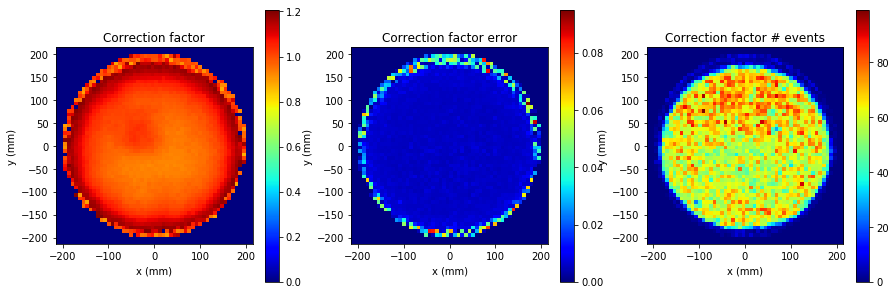

In [4]:
fcorr = tb.open_file(corr_file,'r')

# Fill arrays containing the information in the correction table.
corr_x = []; corr_y = []; corr_fs = []; corr_us = []; corr_nevt = []
xyc = fcorr.root.Corrections.XYcorrections
for r in range(len(xyc)):
    corr_x.append(xyc[r]['x'])
    corr_y.append(xyc[r]['y'])
    corr_fs.append(xyc[r]['factor'])
    corr_us.append(xyc[r]['uncertainty'])
    corr_nevt.append(xyc[r]['nevt'])
corr_x = np.array(corr_x)
corr_y = np.array(corr_y)
corr_fs = np.array(corr_fs)
corr_us = np.array(corr_us)
corr_nevt = np.array(corr_nevt)
maxf = np.max(corr_fs)

# ---------------------------------------------
# Plots

fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(15.0);

# correction factor
ax1 = fig.add_subplot(131);
ax1.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (ncbins, ncbins), ((-215, 215), (-215, 215)), weights=corr_fs, cmap='jet', vmin=0, vmax=maxf)
plt.colorbar()
ax1.set_title("Correction factor")
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")

# correction factor error
ax2 = fig.add_subplot(132)
#plt.axes().set_aspect('equal')
ax2.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (ncbins, ncbins), ((-215, 215), (-215, 215)), weights=corr_us, cmap='jet')
plt.colorbar()
ax2.set_title("Correction factor error")
ax2.set_xlabel("x (mm)")
ax2.set_ylabel("y (mm)")

# correction factor statistics
ax3 = fig.add_subplot(133)
#plt.axes().set_aspect('equal')
ax3.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (ncbins, ncbins), ((-215, 215), (-215, 215)), weights=corr_nevt, cmap='jet')
plt.colorbar()
ax3.set_title("Correction factor # events")
ax3.set_xlabel("x (mm)")
ax3.set_ylabel("y (mm)")

# get the x and y bin sizes
xdiff = corr_x[1:] - corr_x[0:-1]
nz_xdiff = np.nonzero(xdiff)[0]
xbin = xdiff[nz_xdiff][0]
xcmin = np.min(corr_x)

ydiff = corr_y[1:] - corr_y[0:-1]
nz_ydiff = np.nonzero(ydiff)[0]
ybin = ydiff[np.nonzero(ydiff)][0]
ycmin = np.min(corr_y)

# ---------------------------------------------------
# Create the correction factor table.

ctbl = np.ones([len(nz_xdiff)+1,len(nz_xdiff)+1])-2
for x,y,fs in zip(corr_x,corr_y,corr_fs):
    xb = int((x-xcmin)/xbin)
    yb = int((y-ycmin)/ybin)
    ctbl[xb][yb] = fs
    #print("Filled ({0},{1}) with {2} for x = {3} and y = {4}".format(xb,yb,fs,x,y))
if(len(ctbl[ctbl < 0]) > 0):
    print("ERROR: value in correction table not filled")
print("Correction table with shape: {0}; bin sizes ({1},{2})".format(ctbl.shape,xbin,ybin))

# Define a function that returns the correction factor for a given (x,y).
def fcorr(x,y):
    xb = max(0,min(ctbl.shape[0]-1,((x-xcmin)/xbin).astype(int)))
    yb = max(0,min(ctbl.shape[1]-1,((y-ycmin)/ybin).astype(int)))

    if hasattr(xb, "__len__"):
        cf = [ctbl[xx][yy] for xx,yy in zip(xb,yb)]
        return cf
    else:
        return ctbl[xb][yb]

## Read in the output of Penthesilea
Reads in Penthesilea output from the runs listed

In [5]:
def merge_NN_hits(hits_all,hits_nonNN):

    # Iterate through the nonNN dictionary and update the energies including the NN hits from the "all" dictionary.
    for (evt,hc) in hits_nonNN.items():

        # Get the corresponding collection of all hits.
        hc_all = hits_all[evt]
            
        # Add energy from all NN hits to hits in closest slice.
        for h1 in hc_all.hits:

            if(h1.Q == NN):

                # Find the hits to which the energy will be added.
                zdist_min = -1
                h_add = []
                for h2 in hc.hits:
                    zdist = np.abs(h1.Z - h2.Z)
                    if(zdist_min < 0 or zdist < zdist_min):
                        zdist_min = zdist
                        h_add = []
                        h_add.append(h2)
                    elif(zdist == zdist_min):
                        h_add.append(h2)

                # Add the energy.
                hadd_etot = sum([ha.E for ha in h_add])
                for ha in h_add:
                    ha.energy += h1.E*(ha.E/hadd_etot)
                    
        # Check the sum of the energy
        #e1 = sum([hh.E for hh in hc_all.hits])
        #e2 = sum([hh.E for hh in hc.hits])
        #if(abs(e1 - e2) > 0.001):
        #    print("ERROR")


In [6]:
# run numbers and lifetime values for correction
l_rnum = [4595]
l_tlife = [1387]
l_mucorr = [1.0]
#l_rnum   = [4595,   4597,   4599,   4601,   4603,   4605,   4607,   4609,   4611,   4613,   4615]
#l_tlife  = [1387,1438,1456,1460,1455,1463,1478,1488,1479,1501,1505]
#l_tlife  = [1387+50,1438+50,1456+50,1460+50,1455+50,1463+50,1478+50,1488+50,1479+50,1501+50,1505+50]
#l_mucorr = [1.0,    1.0,    1.0,    1.0,    1.0,    1.0,    1.0,    1.0,    1.0,    1.0]  # set to 1 for now
#l_mucorr = [1.0034, 1.0036, 1.0050, 1.0051, 1.0001, 1.0004, 1.0010]

# overall energy cuts
ECCUT_LOW = 250000
ECCUT_HIGH = 1000000

In [7]:
l_hitc = []
for rnum in l_rnum:
    
    fname = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/{0}/tracks/tracks_{1}.h5".format(rnum,rnum)
    hits_all = load_hits(fname)
    hits = load_hits_skipping_NN(fname)

    # Modifies the list of non-NN hits.
    merge_NN_hits(hits_all,hits)
    
    # Save the hit collection that no longer contains NN hits.
    l_hitc.append(hits)

In [8]:
# Create the corrected hit collections (summed over all runs) for 
#  fully corrected (c) and geometry-only corrected (g) events.
hitc_cevt = []; hitc_gevt = []
for hitc, tlife, mucorr in zip(l_hitc,l_tlife,l_mucorr):

    for ee,hc in hitc.items():
        hc_corr = []; hc_gcorr = []
        for hh in hc.hits:
            hecorr = hh.E*mucorr*fcorr(hh.X,hh.Y)/np.exp(-hh.Z/tlife)
            hegcorr = hh.E*mucorr*fcorr(hh.X,hh.Y)
            hcorr = Hit(0,Cluster(0, xy(hh.X,hh.Y), xy(0,0), 0),hh.Z,hecorr)
            hgcorr = Hit(0,Cluster(0, xy(hh.X,hh.Y), xy(0,0), 0),hh.Z,hegcorr)
            hc_corr.append(hcorr); hc_gcorr.append(hgcorr)
        
        # Only save events with >= 2 hits.
        if(len(hc_corr) >= 2):
            hitc_cevt.append(hc_corr)
            hitc_gevt.append(hc_gcorr)

---------------------------

# Paolina analysis

In [15]:
vol_min = np.array([-250, -250, -100],dtype=np.int16)  # volume minimum (x,y,z)
vol_max = np.array([250, 250, 400],dtype=np.int16)  # volume maximum (x,y,z)
vox_size = np.array([15,15,15],dtype=np.int16)    # voxel size
blob_radius = 21.                    # blob radius in mm
DIST_CUT = 60.
EBLOB_CUT = 300000
CAL_FACTOR = 1620/486000

In [13]:
# run Paolina for many events: note we now assume that all events have >= 2 hits
trk_energies = []; 
l_eblob1 = []; l_eblob2 = []; l_eevt = []; l_etrk = []; l_ntrk = []; l_ltrk = []; l_nvox = []
for nevt in range(len(hitc_cevt)):
    
    hitc = hitc_cevt[nevt]
    
    # Calculate event coordinates and corrected energy.
    evt_X = sum([hh.X*hh.E for hh in hitc_cevt[nevt]])
    evt_Y = sum([hh.Y*hh.E for hh in hitc_cevt[nevt]])
    evt_Z = sum([hh.Z*hh.E for hh in hitc_cevt[nevt]])
    evt_E = sum([hh.E for hh in hitc_cevt[nevt]])
    if(len(hitc_cevt[nevt]) > 0):
        evt_X /= evt_E
        evt_Y /= evt_E
        evt_Z /= evt_E
    evt_R = np.sqrt(evt_X**2 + evt_Y**2)

    print("Track {0} with {1} hits...".format(nevt,len(hitc)))

    voxels = plf.voxelize_hits(hitc,vox_size)
    trks = plf.make_track_graphs(voxels,vox_size)
    l_etrks_all = []
    for t in trks:
        if(len(t.nodes()) < 1):
            etrk = 0
        else:
            etrk = sum([vox.E for vox in t.nodes()])
        l_etrks_all.append(etrk)
        trk_energies.append(etrk)
    #itmax = np.argmax([len(t) for t in trks])  # max track is the one with most voxels
    
    Eblob1 = -1; Eblob2 = -1; etmax = -1; ltrk = -1
    if(len(l_etrks_all) > 0):
        itmax = np.argmax(l_etrks_all)              # max track is the one with the most energy
        etmax = sum([vox.E for vox in trks[itmax].nodes()])

        eblobs = plf.blob_energies(trks[itmax],blob_radius)
        iter_eblobs = iter(eblobs)
        Eblob1, Eblob2 = next(iter_eblobs),next(iter_eblobs)

        # ensure blob2 always has higher energy
        if(Eblob1 > Eblob2):
            eswap = Eblob1
            Eblob1 = Eblob2
            Eblob2 = eswap

        # get the extremes
        distances = plf.shortest_paths(trks[itmax])
        a,b = plf.find_extrema(distances)
        ltrk = distances[a][b]
        print("Found {0} tracks of {1}; max containing {2} voxels; total of {3} voxels, distance = {4}".format(len(trks),len(hitc_cevt),len(trks[itmax]),len(voxels),distances[a][b]))

    # add to the distributions
    l_eblob1.append(Eblob1)
    l_eblob2.append(Eblob2)
    l_eevt.append(evt_E)
    l_etrk.append(etmax)
    l_ntrk.append(len(trks))
    l_ltrk.append(ltrk)
    l_nvox.append(len(voxels))

l_eblob1 = np.array(l_eblob1)
l_eblob2 = np.array(l_eblob2)
l_eevt = np.array(l_eevt)
l_etrk = np.array(l_etrk)
l_ntrk = np.array(l_ntrk)
l_ltrk = np.array(l_ltrk)
l_nvox = np.array(l_nvox)

Track 0 with 42 hits...
Found 1 tracks of 5839; max containing 19 voxels; total of 19 voxels, distance = 69.98942685898184
Track 1 with 43 hits...
Found 1 tracks of 5839; max containing 22 voxels; total of 22 voxels, distance = 158.34935043099088
Track 2 with 76 hits...
Found 4 tracks of 5839; max containing 11 voxels; total of 36 voxels, distance = 101.94293286339587
Track 3 with 61 hits...
Found 2 tracks of 5839; max containing 31 voxels; total of 32 voxels, distance = 281.756905767551
Track 4 with 41 hits...
Found 1 tracks of 5839; max containing 20 voxels; total of 20 voxels, distance = 232.6134280651454
Track 5 with 41 hits...
Found 2 tracks of 5839; max containing 18 voxels; total of 19 voxels, distance = 134.7064010087191
Track 6 with 46 hits...
Found 1 tracks of 5839; max containing 21 voxels; total of 21 voxels, distance = 88.73872714089612
Track 7 with 48 hits...
Found 4 tracks of 5839; max containing 13 voxels; total of 27 voxels, distance = 102.1866374170954
Track 8 with 52

Found 2 tracks of 5839; max containing 13 voxels; total of 16 voxels, distance = 90.42205447087765
Track 67 with 47 hits...
Found 2 tracks of 5839; max containing 20 voxels; total of 22 voxels, distance = 71.9841667134954
Track 68 with 43 hits...
Found 1 tracks of 5839; max containing 19 voxels; total of 19 voxels, distance = 89.26158898233531
Track 69 with 38 hits...
Found 1 tracks of 5839; max containing 19 voxels; total of 19 voxels, distance = 153.3273036908906
Track 70 with 81 hits...
Found 2 tracks of 5839; max containing 39 voxels; total of 46 voxels, distance = 261.22415249069365
Track 71 with 37 hits...
Found 1 tracks of 5839; max containing 21 voxels; total of 21 voxels, distance = 98.63298786315511
Track 72 with 34 hits...
Found 3 tracks of 5839; max containing 17 voxels; total of 21 voxels, distance = 181.79110106839659
Track 73 with 43 hits...
Found 3 tracks of 5839; max containing 19 voxels; total of 21 voxels, distance = 86.21465605886135
Track 74 with 28 hits...
Found 4

Found 1 tracks of 5839; max containing 26 voxels; total of 26 voxels, distance = 116.00226995987288
Track 133 with 31 hits...
Found 6 tracks of 5839; max containing 4 voxels; total of 14 voxels, distance = 31.932355498894303
Track 134 with 30 hits...
Found 2 tracks of 5839; max containing 15 voxels; total of 16 voxels, distance = 72.81711449829099
Track 135 with 59 hits...
Found 1 tracks of 5839; max containing 26 voxels; total of 26 voxels, distance = 73.39705868279985
Track 136 with 61 hits...
Found 6 tracks of 5839; max containing 8 voxels; total of 28 voxels, distance = 60.78215585184076
Track 137 with 55 hits...
Found 1 tracks of 5839; max containing 24 voxels; total of 24 voxels, distance = 116.45318522374058
Track 138 with 50 hits...
Found 3 tracks of 5839; max containing 21 voxels; total of 27 voxels, distance = 154.53896346780755
Track 139 with 37 hits...
Found 5 tracks of 5839; max containing 6 voxels; total of 18 voxels, distance = 35.718466363345414
Track 140 with 34 hits..

Found 2 tracks of 5839; max containing 28 voxels; total of 29 voxels, distance = 195.30382453616778
Track 200 with 48 hits...
Found 3 tracks of 5839; max containing 15 voxels; total of 20 voxels, distance = 57.89756761844953
Track 201 with 52 hits...
Found 5 tracks of 5839; max containing 12 voxels; total of 30 voxels, distance = 129.38205229461028
Track 202 with 32 hits...
Found 1 tracks of 5839; max containing 14 voxels; total of 14 voxels, distance = 122.14677089323585
Track 203 with 51 hits...
Found 2 tracks of 5839; max containing 26 voxels; total of 27 voxels, distance = 93.08501203617028
Track 204 with 41 hits...
Found 4 tracks of 5839; max containing 12 voxels; total of 20 voxels, distance = 94.46353147532791
Track 205 with 57 hits...
Found 2 tracks of 5839; max containing 21 voxels; total of 22 voxels, distance = 201.20855919739992
Track 206 with 38 hits...
Found 2 tracks of 5839; max containing 11 voxels; total of 16 voxels, distance = 101.2692980024316
Track 207 with 34 hits

Found 1 tracks of 5839; max containing 18 voxels; total of 18 voxels, distance = 77.2243875964863
Track 266 with 38 hits...
Found 4 tracks of 5839; max containing 6 voxels; total of 17 voxels, distance = 39.13547328797612
Track 267 with 35 hits...
Found 3 tracks of 5839; max containing 12 voxels; total of 15 voxels, distance = 71.81064249184165
Track 268 with 41 hits...
Found 2 tracks of 5839; max containing 14 voxels; total of 18 voxels, distance = 101.57420003813101
Track 269 with 50 hits...
Found 1 tracks of 5839; max containing 23 voxels; total of 23 voxels, distance = 187.41297036556966
Track 270 with 35 hits...
Found 2 tracks of 5839; max containing 14 voxels; total of 16 voxels, distance = 71.76676881968883
Track 271 with 45 hits...
Found 2 tracks of 5839; max containing 20 voxels; total of 22 voxels, distance = 60.86162404556816
Track 272 with 49 hits...
Found 1 tracks of 5839; max containing 24 voxels; total of 24 voxels, distance = 119.06469137138289
Track 273 with 52 hits...

Found 1 tracks of 5839; max containing 32 voxels; total of 32 voxels, distance = 218.19479619212981
Track 332 with 24 hits...
Found 3 tracks of 5839; max containing 14 voxels; total of 17 voxels, distance = 43.37121922180045
Track 333 with 41 hits...
Found 1 tracks of 5839; max containing 15 voxels; total of 15 voxels, distance = 119.90838163789832
Track 334 with 51 hits...
Found 5 tracks of 5839; max containing 8 voxels; total of 22 voxels, distance = 50.62682774915581
Track 335 with 24 hits...
Found 1 tracks of 5839; max containing 13 voxels; total of 13 voxels, distance = 150.66712674086546
Track 336 with 70 hits...
Found 2 tracks of 5839; max containing 27 voxels; total of 37 voxels, distance = 247.59443558437738
Track 337 with 43 hits...
Found 2 tracks of 5839; max containing 23 voxels; total of 26 voxels, distance = 161.15752052051482
Track 338 with 35 hits...
Found 2 tracks of 5839; max containing 10 voxels; total of 15 voxels, distance = 53.2269004355158
Track 339 with 48 hits.

Found 2 tracks of 5839; max containing 15 voxels; total of 22 voxels, distance = 149.91464080075622
Track 400 with 44 hits...
Found 2 tracks of 5839; max containing 16 voxels; total of 23 voxels, distance = 69.92041564047732
Track 401 with 38 hits...
Found 3 tracks of 5839; max containing 15 voxels; total of 20 voxels, distance = 61.01468196381775
Track 402 with 43 hits...
Found 1 tracks of 5839; max containing 22 voxels; total of 22 voxels, distance = 180.68680524204905
Track 403 with 41 hits...
Found 4 tracks of 5839; max containing 8 voxels; total of 20 voxels, distance = 69.35678918596611
Track 404 with 50 hits...
Found 4 tracks of 5839; max containing 19 voxels; total of 24 voxels, distance = 77.97940139219472
Track 405 with 34 hits...
Found 3 tracks of 5839; max containing 15 voxels; total of 18 voxels, distance = 79.86017562054437
Track 406 with 34 hits...
Found 2 tracks of 5839; max containing 13 voxels; total of 14 voxels, distance = 127.74394453999295
Track 407 with 62 hits..

Found 2 tracks of 5839; max containing 20 voxels; total of 21 voxels, distance = 187.52332581621437
Track 467 with 45 hits...
Found 1 tracks of 5839; max containing 20 voxels; total of 20 voxels, distance = 115.1292284271547
Track 468 with 51 hits...
Found 1 tracks of 5839; max containing 25 voxels; total of 25 voxels, distance = 170.6438415858784
Track 469 with 41 hits...
Found 2 tracks of 5839; max containing 18 voxels; total of 20 voxels, distance = 88.27669304671105
Track 470 with 61 hits...
Found 2 tracks of 5839; max containing 30 voxels; total of 36 voxels, distance = 106.08121107787403
Track 471 with 40 hits...
Found 2 tracks of 5839; max containing 23 voxels; total of 24 voxels, distance = 161.88488948172957
Track 472 with 48 hits...
Found 5 tracks of 5839; max containing 16 voxels; total of 20 voxels, distance = 95.15075540743433
Track 473 with 39 hits...
Found 1 tracks of 5839; max containing 17 voxels; total of 17 voxels, distance = 124.44239826478872
Track 474 with 38 hits

Found 2 tracks of 5839; max containing 26 voxels; total of 28 voxels, distance = 173.2729230631246
Track 533 with 30 hits...
Found 2 tracks of 5839; max containing 10 voxels; total of 13 voxels, distance = 55.08302840646188
Track 534 with 37 hits...
Found 1 tracks of 5839; max containing 13 voxels; total of 13 voxels, distance = 75.67745682934788
Track 535 with 72 hits...
Found 4 tracks of 5839; max containing 10 voxels; total of 35 voxels, distance = 69.48493708507769
Track 536 with 52 hits...
Found 1 tracks of 5839; max containing 28 voxels; total of 28 voxels, distance = 123.61430478699546
Track 537 with 29 hits...
Found 2 tracks of 5839; max containing 10 voxels; total of 12 voxels, distance = 58.470116709826094
Track 538 with 38 hits...
Found 2 tracks of 5839; max containing 11 voxels; total of 19 voxels, distance = 85.41712070814633
Track 539 with 37 hits...
Found 3 tracks of 5839; max containing 13 voxels; total of 18 voxels, distance = 133.88823637124347
Track 540 with 40 hits.

Found 1 tracks of 5839; max containing 34 voxels; total of 34 voxels, distance = 131.62901433079003
Track 599 with 35 hits...
Found 2 tracks of 5839; max containing 15 voxels; total of 16 voxels, distance = 74.74082473042073
Track 600 with 55 hits...
Found 3 tracks of 5839; max containing 17 voxels; total of 21 voxels, distance = 97.69335556934355
Track 601 with 32 hits...
Found 2 tracks of 5839; max containing 10 voxels; total of 18 voxels, distance = 63.804658929342494
Track 602 with 42 hits...
Found 1 tracks of 5839; max containing 25 voxels; total of 25 voxels, distance = 167.4361188784937
Track 603 with 45 hits...
Found 1 tracks of 5839; max containing 21 voxels; total of 21 voxels, distance = 144.88067320121036
Track 604 with 48 hits...
Found 2 tracks of 5839; max containing 24 voxels; total of 25 voxels, distance = 95.74023394423904
Track 605 with 29 hits...
Found 3 tracks of 5839; max containing 6 voxels; total of 13 voxels, distance = 39.22384486739943
Track 606 with 47 hits..

Found 1 tracks of 5839; max containing 21 voxels; total of 21 voxels, distance = 131.62883461730806
Track 667 with 29 hits...
Found 1 tracks of 5839; max containing 13 voxels; total of 13 voxels, distance = 140.2647120475283
Track 668 with 61 hits...
Found 3 tracks of 5839; max containing 24 voxels; total of 31 voxels, distance = 84.68386272252096
Track 669 with 34 hits...
Found 2 tracks of 5839; max containing 9 voxels; total of 11 voxels, distance = 71.8467174302491
Track 670 with 38 hits...
Found 1 tracks of 5839; max containing 17 voxels; total of 17 voxels, distance = 120.68158734704106
Track 671 with 34 hits...
Found 3 tracks of 5839; max containing 7 voxels; total of 16 voxels, distance = 48.05230658579532
Track 672 with 55 hits...
Found 1 tracks of 5839; max containing 25 voxels; total of 25 voxels, distance = 116.88567902499236
Track 673 with 44 hits...
Found 4 tracks of 5839; max containing 15 voxels; total of 20 voxels, distance = 52.162316373019095
Track 674 with 43 hits...

Found 2 tracks of 5839; max containing 23 voxels; total of 24 voxels, distance = 204.34596652320903
Track 734 with 45 hits...
Found 2 tracks of 5839; max containing 16 voxels; total of 17 voxels, distance = 169.71441148548934
Track 735 with 42 hits...
Found 2 tracks of 5839; max containing 11 voxels; total of 19 voxels, distance = 62.52169364341398
Track 736 with 51 hits...
Found 4 tracks of 5839; max containing 11 voxels; total of 25 voxels, distance = 78.66317390151383
Track 737 with 60 hits...
Found 7 tracks of 5839; max containing 17 voxels; total of 32 voxels, distance = 94.55045319718357
Track 738 with 44 hits...
Found 2 tracks of 5839; max containing 11 voxels; total of 18 voxels, distance = 71.84190888036342
Track 739 with 53 hits...
Found 2 tracks of 5839; max containing 14 voxels; total of 23 voxels, distance = 64.86157637979062
Track 740 with 36 hits...
Found 1 tracks of 5839; max containing 21 voxels; total of 21 voxels, distance = 123.5733361416633
Track 741 with 43 hits..

Found 1 tracks of 5839; max containing 24 voxels; total of 24 voxels, distance = 160.31801865708184
Track 799 with 66 hits...
Found 3 tracks of 5839; max containing 22 voxels; total of 28 voxels, distance = 189.34438996252933
Track 800 with 45 hits...
Found 1 tracks of 5839; max containing 21 voxels; total of 21 voxels, distance = 127.8251965748956
Track 801 with 37 hits...
Found 4 tracks of 5839; max containing 16 voxels; total of 22 voxels, distance = 83.08675465397413
Track 802 with 59 hits...
Found 1 tracks of 5839; max containing 28 voxels; total of 28 voxels, distance = 77.6763692562645
Track 803 with 37 hits...
Found 3 tracks of 5839; max containing 9 voxels; total of 19 voxels, distance = 67.47469118580466
Track 804 with 46 hits...
Found 5 tracks of 5839; max containing 5 voxels; total of 20 voxels, distance = 33.24163876442037
Track 805 with 36 hits...
Found 3 tracks of 5839; max containing 9 voxels; total of 17 voxels, distance = 83.28523839719657
Track 806 with 55 hits...
Fo

Found 2 tracks of 5839; max containing 26 voxels; total of 27 voxels, distance = 108.34918307882714
Track 865 with 53 hits...
Found 1 tracks of 5839; max containing 24 voxels; total of 24 voxels, distance = 130.83392767525888
Track 866 with 36 hits...
Found 2 tracks of 5839; max containing 10 voxels; total of 12 voxels, distance = 100.74196605824905
Track 867 with 30 hits...
Found 3 tracks of 5839; max containing 7 voxels; total of 13 voxels, distance = 45.676470954351224
Track 868 with 73 hits...
Found 2 tracks of 5839; max containing 27 voxels; total of 34 voxels, distance = 268.59832361009853
Track 869 with 23 hits...
Found 6 tracks of 5839; max containing 2 voxels; total of 9 voxels, distance = 14.93093627244798
Track 870 with 46 hits...
Found 2 tracks of 5839; max containing 17 voxels; total of 18 voxels, distance = 87.23072998843642
Track 871 with 56 hits...
Found 1 tracks of 5839; max containing 24 voxels; total of 24 voxels, distance = 76.66070569450535
Track 872 with 52 hits..

Found 2 tracks of 5839; max containing 12 voxels; total of 18 voxels, distance = 81.69019950717103
Track 931 with 43 hits...
Found 1 tracks of 5839; max containing 20 voxels; total of 20 voxels, distance = 99.36641761485346
Track 932 with 39 hits...
Found 2 tracks of 5839; max containing 16 voxels; total of 17 voxels, distance = 114.97150490250024
Track 933 with 66 hits...
Found 2 tracks of 5839; max containing 30 voxels; total of 31 voxels, distance = 132.52730476668754
Track 934 with 46 hits...
Found 3 tracks of 5839; max containing 15 voxels; total of 24 voxels, distance = 62.721781047622486
Track 935 with 39 hits...
Found 2 tracks of 5839; max containing 18 voxels; total of 19 voxels, distance = 178.91011061565447
Track 936 with 27 hits...
Found 2 tracks of 5839; max containing 13 voxels; total of 15 voxels, distance = 47.20972808648578
Track 937 with 46 hits...
Found 1 tracks of 5839; max containing 23 voxels; total of 23 voxels, distance = 103.62903494007938
Track 938 with 80 hit

Found 1 tracks of 5839; max containing 21 voxels; total of 21 voxels, distance = 135.69318303643166
Track 999 with 34 hits...
Found 1 tracks of 5839; max containing 12 voxels; total of 12 voxels, distance = 92.2392945224004
Track 1000 with 37 hits...
Found 2 tracks of 5839; max containing 12 voxels; total of 13 voxels, distance = 118.42421243214116
Track 1001 with 56 hits...
Found 6 tracks of 5839; max containing 23 voxels; total of 32 voxels, distance = 65.13159718758976
Track 1002 with 40 hits...
Found 1 tracks of 5839; max containing 23 voxels; total of 23 voxels, distance = 170.07726128037498
Track 1003 with 38 hits...
Found 1 tracks of 5839; max containing 22 voxels; total of 22 voxels, distance = 147.49813295050495
Track 1004 with 66 hits...
Found 2 tracks of 5839; max containing 26 voxels; total of 35 voxels, distance = 180.04129019122513
Track 1005 with 38 hits...
Found 6 tracks of 5839; max containing 7 voxels; total of 18 voxels, distance = 51.89247781572513
Track 1006 with 4

Found 2 tracks of 5839; max containing 23 voxels; total of 31 voxels, distance = 149.11004154516263
Track 1066 with 70 hits...
Found 4 tracks of 5839; max containing 23 voxels; total of 27 voxels, distance = 126.86207988626028
Track 1067 with 35 hits...
Found 1 tracks of 5839; max containing 22 voxels; total of 22 voxels, distance = 105.92972107203855
Track 1068 with 40 hits...
Found 2 tracks of 5839; max containing 12 voxels; total of 22 voxels, distance = 61.01678253212897
Track 1069 with 54 hits...
Found 2 tracks of 5839; max containing 19 voxels; total of 20 voxels, distance = 134.14021842156797
Track 1070 with 34 hits...
Found 3 tracks of 5839; max containing 6 voxels; total of 19 voxels, distance = 63.318684405352144
Track 1071 with 65 hits...
Found 4 tracks of 5839; max containing 24 voxels; total of 28 voxels, distance = 134.65008723683158
Track 1072 with 39 hits...
Found 1 tracks of 5839; max containing 19 voxels; total of 19 voxels, distance = 73.33994728710638
Track 1073 wit

Found 4 tracks of 5839; max containing 14 voxels; total of 18 voxels, distance = 78.95970978028582
Track 1132 with 38 hits...
Found 2 tracks of 5839; max containing 15 voxels; total of 19 voxels, distance = 96.41853917408633
Track 1133 with 38 hits...
Found 1 tracks of 5839; max containing 15 voxels; total of 15 voxels, distance = 67.43467979458335
Track 1134 with 51 hits...
Found 1 tracks of 5839; max containing 24 voxels; total of 24 voxels, distance = 219.19378920149734
Track 1135 with 52 hits...
Found 3 tracks of 5839; max containing 16 voxels; total of 22 voxels, distance = 142.91834837826596
Track 1136 with 32 hits...
Found 1 tracks of 5839; max containing 13 voxels; total of 13 voxels, distance = 66.76816797222405
Track 1137 with 59 hits...
Found 3 tracks of 5839; max containing 29 voxels; total of 35 voxels, distance = 210.44641265735441
Track 1138 with 34 hits...
Found 3 tracks of 5839; max containing 12 voxels; total of 14 voxels, distance = 108.20187947142576
Track 1139 with

Found 1 tracks of 5839; max containing 21 voxels; total of 21 voxels, distance = 97.87760427878327
Track 1197 with 39 hits...
Found 1 tracks of 5839; max containing 17 voxels; total of 17 voxels, distance = 127.21298538479824
Track 1198 with 53 hits...
Found 2 tracks of 5839; max containing 20 voxels; total of 23 voxels, distance = 89.61227534229398
Track 1199 with 46 hits...
Found 1 tracks of 5839; max containing 21 voxels; total of 21 voxels, distance = 129.59308151429303
Track 1200 with 38 hits...
Found 1 tracks of 5839; max containing 18 voxels; total of 18 voxels, distance = 141.7849881895172
Track 1201 with 36 hits...
Found 1 tracks of 5839; max containing 20 voxels; total of 20 voxels, distance = 175.3989537520118
Track 1202 with 70 hits...
Found 3 tracks of 5839; max containing 25 voxels; total of 31 voxels, distance = 177.37197382906263
Track 1203 with 37 hits...
Found 1 tracks of 5839; max containing 15 voxels; total of 15 voxels, distance = 149.90017030256064
Track 1204 with

Found 2 tracks of 5839; max containing 20 voxels; total of 21 voxels, distance = 127.0065815243206
Track 1263 with 37 hits...
Found 1 tracks of 5839; max containing 17 voxels; total of 17 voxels, distance = 64.83395286339976
Track 1264 with 49 hits...
Found 1 tracks of 5839; max containing 23 voxels; total of 23 voxels, distance = 109.99623350789406
Track 1265 with 33 hits...
Found 2 tracks of 5839; max containing 17 voxels; total of 19 voxels, distance = 64.6618324503204
Track 1266 with 41 hits...
Found 1 tracks of 5839; max containing 21 voxels; total of 21 voxels, distance = 117.31083416330246
Track 1267 with 68 hits...
Found 3 tracks of 5839; max containing 29 voxels; total of 31 voxels, distance = 194.6971401577296
Track 1268 with 35 hits...
Found 1 tracks of 5839; max containing 15 voxels; total of 15 voxels, distance = 103.20967518487379
Track 1269 with 44 hits...
Found 1 tracks of 5839; max containing 24 voxels; total of 24 voxels, distance = 87.84267048766385
Track 1270 with 8

Found 2 tracks of 5839; max containing 17 voxels; total of 18 voxels, distance = 80.75670702924128
Track 1328 with 81 hits...
Found 2 tracks of 5839; max containing 39 voxels; total of 40 voxels, distance = 303.73127392317195
Track 1329 with 45 hits...
Found 5 tracks of 5839; max containing 11 voxels; total of 20 voxels, distance = 58.77461662469009
Track 1330 with 55 hits...
Found 3 tracks of 5839; max containing 26 voxels; total of 28 voxels, distance = 140.4012924082706
Track 1331 with 51 hits...
Found 1 tracks of 5839; max containing 27 voxels; total of 27 voxels, distance = 181.44624221050526
Track 1332 with 43 hits...
Found 2 tracks of 5839; max containing 19 voxels; total of 22 voxels, distance = 154.6416105011361
Track 1333 with 39 hits...
Found 3 tracks of 5839; max containing 13 voxels; total of 17 voxels, distance = 56.5936441065183
Track 1334 with 33 hits...
Found 1 tracks of 5839; max containing 14 voxels; total of 14 voxels, distance = 74.36510776512488
Track 1335 with 36

Found 1 tracks of 5839; max containing 22 voxels; total of 22 voxels, distance = 124.90313765573777
Track 1393 with 52 hits...
Found 2 tracks of 5839; max containing 16 voxels; total of 18 voxels, distance = 130.27458663170498
Track 1394 with 43 hits...
Found 1 tracks of 5839; max containing 22 voxels; total of 22 voxels, distance = 141.60339710473204
Track 1395 with 61 hits...
Found 4 tracks of 5839; max containing 23 voxels; total of 28 voxels, distance = 186.29108795607004
Track 1396 with 41 hits...
Found 2 tracks of 5839; max containing 14 voxels; total of 18 voxels, distance = 57.9109039778348
Track 1397 with 60 hits...
Found 2 tracks of 5839; max containing 27 voxels; total of 28 voxels, distance = 156.94252937262908
Track 1398 with 33 hits...
Found 2 tracks of 5839; max containing 10 voxels; total of 11 voxels, distance = 66.3506381050884
Track 1399 with 67 hits...
Found 3 tracks of 5839; max containing 22 voxels; total of 34 voxels, distance = 105.27161892878661
Track 1400 with

Found 2 tracks of 5839; max containing 32 voxels; total of 33 voxels, distance = 217.23794733852137
Track 1461 with 38 hits...
Found 4 tracks of 5839; max containing 9 voxels; total of 15 voxels, distance = 60.700348972314345
Track 1462 with 35 hits...
Found 1 tracks of 5839; max containing 14 voxels; total of 14 voxels, distance = 62.37097741469236
Track 1463 with 31 hits...
Found 2 tracks of 5839; max containing 13 voxels; total of 16 voxels, distance = 92.95660890561965
Track 1464 with 35 hits...
Found 1 tracks of 5839; max containing 15 voxels; total of 15 voxels, distance = 66.54202264914352
Track 1465 with 52 hits...
Found 1 tracks of 5839; max containing 22 voxels; total of 22 voxels, distance = 186.24287946428177
Track 1466 with 60 hits...
Found 4 tracks of 5839; max containing 15 voxels; total of 27 voxels, distance = 118.2806477811731
Track 1467 with 57 hits...
Found 2 tracks of 5839; max containing 21 voxels; total of 31 voxels, distance = 148.0686767644705
Track 1468 with 3

Found 2 tracks of 5839; max containing 14 voxels; total of 15 voxels, distance = 117.0525750337288
Track 1526 with 50 hits...
Found 2 tracks of 5839; max containing 18 voxels; total of 26 voxels, distance = 98.69745747409608
Track 1527 with 42 hits...
Found 2 tracks of 5839; max containing 15 voxels; total of 23 voxels, distance = 109.236494049078
Track 1528 with 28 hits...
Found 1 tracks of 5839; max containing 13 voxels; total of 13 voxels, distance = 58.944014830027385
Track 1529 with 28 hits...
Found 2 tracks of 5839; max containing 10 voxels; total of 15 voxels, distance = 72.83245793413663
Track 1530 with 50 hits...
Found 6 tracks of 5839; max containing 3 voxels; total of 24 voxels, distance = 25.078269529511914
Track 1531 with 27 hits...
Found 4 tracks of 5839; max containing 6 voxels; total of 12 voxels, distance = 47.52679950104311
Track 1532 with 40 hits...
Found 1 tracks of 5839; max containing 17 voxels; total of 17 voxels, distance = 59.73151760460747
Track 1533 with 38 h

Found 1 tracks of 5839; max containing 20 voxels; total of 20 voxels, distance = 130.4256170774134
Track 1592 with 48 hits...
Found 1 tracks of 5839; max containing 20 voxels; total of 20 voxels, distance = 180.84700022683302
Track 1593 with 40 hits...
Found 1 tracks of 5839; max containing 19 voxels; total of 19 voxels, distance = 61.32815144140963
Track 1594 with 62 hits...
Found 2 tracks of 5839; max containing 23 voxels; total of 34 voxels, distance = 170.37686323668504
Track 1595 with 54 hits...
Found 2 tracks of 5839; max containing 24 voxels; total of 25 voxels, distance = 86.52106415188443
Track 1596 with 72 hits...
Found 4 tracks of 5839; max containing 26 voxels; total of 32 voxels, distance = 192.64351953280624
Track 1597 with 35 hits...
Found 1 tracks of 5839; max containing 15 voxels; total of 15 voxels, distance = 81.1652865379574
Track 1598 with 35 hits...
Found 1 tracks of 5839; max containing 15 voxels; total of 15 voxels, distance = 85.03111319179808
Track 1599 with 5

Found 3 tracks of 5839; max containing 22 voxels; total of 26 voxels, distance = 128.80217491699483
Track 1657 with 34 hits...
Found 2 tracks of 5839; max containing 10 voxels; total of 13 voxels, distance = 104.8504562242987
Track 1658 with 55 hits...
Found 4 tracks of 5839; max containing 21 voxels; total of 31 voxels, distance = 146.87777370272923
Track 1659 with 66 hits...
Found 2 tracks of 5839; max containing 27 voxels; total of 36 voxels, distance = 165.627259323092
Track 1660 with 46 hits...
Found 1 tracks of 5839; max containing 24 voxels; total of 24 voxels, distance = 160.20960856197675
Track 1661 with 55 hits...
Found 2 tracks of 5839; max containing 24 voxels; total of 25 voxels, distance = 140.1094753941218
Track 1662 with 35 hits...
Found 2 tracks of 5839; max containing 17 voxels; total of 18 voxels, distance = 109.3960429228065
Track 1663 with 67 hits...
Found 3 tracks of 5839; max containing 28 voxels; total of 32 voxels, distance = 214.67467694679837
Track 1664 with 

Found 1 tracks of 5839; max containing 17 voxels; total of 17 voxels, distance = 91.17768260632317
Track 1722 with 68 hits...
Found 1 tracks of 5839; max containing 32 voxels; total of 32 voxels, distance = 151.57635377251626
Track 1723 with 29 hits...
Found 2 tracks of 5839; max containing 13 voxels; total of 18 voxels, distance = 49.34752947965045
Track 1724 with 49 hits...
Found 3 tracks of 5839; max containing 18 voxels; total of 20 voxels, distance = 93.2442421626148
Track 1725 with 59 hits...
Found 1 tracks of 5839; max containing 30 voxels; total of 30 voxels, distance = 182.50543593393294
Track 1726 with 29 hits...
Found 2 tracks of 5839; max containing 10 voxels; total of 13 voxels, distance = 90.55497992189382
Track 1727 with 36 hits...
Found 2 tracks of 5839; max containing 9 voxels; total of 18 voxels, distance = 39.236585935352046
Track 1728 with 47 hits...
Found 3 tracks of 5839; max containing 14 voxels; total of 21 voxels, distance = 56.63990039231978
Track 1729 with 34

Found 1 tracks of 5839; max containing 26 voxels; total of 26 voxels, distance = 178.23044981256896
Track 1787 with 53 hits...
Found 1 tracks of 5839; max containing 26 voxels; total of 26 voxels, distance = 114.88213117535103
Track 1788 with 34 hits...
Found 2 tracks of 5839; max containing 10 voxels; total of 14 voxels, distance = 71.59598012215912
Track 1789 with 59 hits...
Found 2 tracks of 5839; max containing 26 voxels; total of 27 voxels, distance = 170.42190748440217
Track 1790 with 54 hits...
Found 5 tracks of 5839; max containing 17 voxels; total of 27 voxels, distance = 118.33441346558196
Track 1791 with 47 hits...
Found 3 tracks of 5839; max containing 12 voxels; total of 17 voxels, distance = 129.32994844993635
Track 1792 with 35 hits...
Found 2 tracks of 5839; max containing 13 voxels; total of 16 voxels, distance = 82.54526084886996
Track 1793 with 51 hits...
Found 1 tracks of 5839; max containing 24 voxels; total of 24 voxels, distance = 133.4434591011277
Track 1794 wit

Found 2 tracks of 5839; max containing 27 voxels; total of 28 voxels, distance = 162.3362117623077
Track 1853 with 42 hits...
Found 1 tracks of 5839; max containing 22 voxels; total of 22 voxels, distance = 104.74302221347627
Track 1854 with 62 hits...
Found 1 tracks of 5839; max containing 32 voxels; total of 32 voxels, distance = 148.86106369838978
Track 1855 with 32 hits...
Found 3 tracks of 5839; max containing 10 voxels; total of 19 voxels, distance = 77.32275821542015
Track 1856 with 38 hits...
Found 2 tracks of 5839; max containing 12 voxels; total of 13 voxels, distance = 56.343446861325056
Track 1857 with 20 hits...
Found 2 tracks of 5839; max containing 6 voxels; total of 11 voxels, distance = 62.98093500935114
Track 1858 with 52 hits...
Found 1 tracks of 5839; max containing 25 voxels; total of 25 voxels, distance = 177.74976965862544
Track 1859 with 50 hits...
Found 2 tracks of 5839; max containing 19 voxels; total of 20 voxels, distance = 87.5136027720096
Track 1860 with 3

Found 2 tracks of 5839; max containing 13 voxels; total of 14 voxels, distance = 86.58641509896553
Track 1919 with 36 hits...
Found 3 tracks of 5839; max containing 13 voxels; total of 20 voxels, distance = 99.51758437321568
Track 1920 with 50 hits...
Found 3 tracks of 5839; max containing 16 voxels; total of 26 voxels, distance = 173.29793964409194
Track 1921 with 79 hits...
Found 3 tracks of 5839; max containing 33 voxels; total of 39 voxels, distance = 254.1999132591263
Track 1922 with 43 hits...
Found 5 tracks of 5839; max containing 12 voxels; total of 27 voxels, distance = 100.92211624409316
Track 1923 with 33 hits...
Found 1 tracks of 5839; max containing 13 voxels; total of 13 voxels, distance = 52.30154123046686
Track 1924 with 49 hits...
Found 3 tracks of 5839; max containing 19 voxels; total of 21 voxels, distance = 77.4703962102586
Track 1925 with 37 hits...
Found 2 tracks of 5839; max containing 20 voxels; total of 21 voxels, distance = 148.82029200815904
Track 1926 with 3

Found 1 tracks of 5839; max containing 36 voxels; total of 36 voxels, distance = 249.55696727360382
Track 1984 with 36 hits...
Found 4 tracks of 5839; max containing 17 voxels; total of 22 voxels, distance = 78.01379756968376
Track 1985 with 29 hits...
Found 3 tracks of 5839; max containing 7 voxels; total of 12 voxels, distance = 39.01171723308576
Track 1986 with 56 hits...
Found 3 tracks of 5839; max containing 32 voxels; total of 34 voxels, distance = 251.85000057755843
Track 1987 with 41 hits...
Found 2 tracks of 5839; max containing 14 voxels; total of 15 voxels, distance = 57.07327651803219
Track 1988 with 48 hits...
Found 3 tracks of 5839; max containing 17 voxels; total of 25 voxels, distance = 87.74868009854848
Track 1989 with 26 hits...
Found 3 tracks of 5839; max containing 4 voxels; total of 11 voxels, distance = 24.646622654803814
Track 1990 with 40 hits...
Found 1 tracks of 5839; max containing 18 voxels; total of 18 voxels, distance = 57.662817497131364
Track 1991 with 4

Found 1 tracks of 5839; max containing 12 voxels; total of 12 voxels, distance = 62.66642020007366
Track 2050 with 48 hits...
Found 7 tracks of 5839; max containing 12 voxels; total of 28 voxels, distance = 59.93323148050091
Track 2051 with 32 hits...
Found 2 tracks of 5839; max containing 15 voxels; total of 18 voxels, distance = 115.14077820543827
Track 2052 with 35 hits...
Found 3 tracks of 5839; max containing 17 voxels; total of 19 voxels, distance = 155.4208882632116
Track 2053 with 54 hits...
Found 3 tracks of 5839; max containing 18 voxels; total of 29 voxels, distance = 215.63704710078724
Track 2054 with 33 hits...
Found 1 tracks of 5839; max containing 17 voxels; total of 17 voxels, distance = 124.73160145740556
Track 2055 with 37 hits...
Found 2 tracks of 5839; max containing 11 voxels; total of 16 voxels, distance = 67.60592717772981
Track 2056 with 38 hits...
Found 1 tracks of 5839; max containing 16 voxels; total of 16 voxels, distance = 75.09351598436575
Track 2057 with 

Found 3 tracks of 5839; max containing 31 voxels; total of 33 voxels, distance = 140.1842288883488
Track 2116 with 34 hits...
Found 2 tracks of 5839; max containing 10 voxels; total of 17 voxels, distance = 37.02973984259606
Track 2117 with 46 hits...
Found 1 tracks of 5839; max containing 23 voxels; total of 23 voxels, distance = 91.37215316103047
Track 2118 with 76 hits...
Found 1 tracks of 5839; max containing 33 voxels; total of 33 voxels, distance = 145.9019138988924
Track 2119 with 32 hits...
Found 1 tracks of 5839; max containing 10 voxels; total of 10 voxels, distance = 62.32854392249999
Track 2120 with 55 hits...
Found 4 tracks of 5839; max containing 5 voxels; total of 27 voxels, distance = 53.710345062162645
Track 2121 with 53 hits...
Found 2 tracks of 5839; max containing 14 voxels; total of 22 voxels, distance = 58.41856183194774
Track 2122 with 49 hits...
Found 1 tracks of 5839; max containing 28 voxels; total of 28 voxels, distance = 101.80641143205807
Track 2123 with 68

Found 1 tracks of 5839; max containing 25 voxels; total of 25 voxels, distance = 139.86093937615263
Track 2181 with 38 hits...
Found 5 tracks of 5839; max containing 12 voxels; total of 23 voxels, distance = 88.57779726065861
Track 2182 with 51 hits...
Found 1 tracks of 5839; max containing 24 voxels; total of 24 voxels, distance = 133.49872301169975
Track 2183 with 60 hits...
Found 10 tracks of 5839; max containing 9 voxels; total of 31 voxels, distance = 98.72014758777216
Track 2184 with 41 hits...
Found 5 tracks of 5839; max containing 11 voxels; total of 22 voxels, distance = 117.6794598389519
Track 2185 with 37 hits...
Found 2 tracks of 5839; max containing 12 voxels; total of 18 voxels, distance = 66.52968259887066
Track 2186 with 31 hits...
Found 1 tracks of 5839; max containing 11 voxels; total of 11 voxels, distance = 55.36910388773511
Track 2187 with 46 hits...
Found 2 tracks of 5839; max containing 14 voxels; total of 20 voxels, distance = 103.34775590538575
Track 2188 with 

Found 2 tracks of 5839; max containing 16 voxels; total of 18 voxels, distance = 76.84612333405546
Track 2247 with 39 hits...
Found 1 tracks of 5839; max containing 19 voxels; total of 19 voxels, distance = 133.36331665385907
Track 2248 with 28 hits...
Found 2 tracks of 5839; max containing 13 voxels; total of 14 voxels, distance = 74.91057464340987
Track 2249 with 37 hits...
Found 1 tracks of 5839; max containing 17 voxels; total of 17 voxels, distance = 126.07979808451692
Track 2250 with 54 hits...
Found 1 tracks of 5839; max containing 24 voxels; total of 24 voxels, distance = 170.15589291514308
Track 2251 with 39 hits...
Found 1 tracks of 5839; max containing 19 voxels; total of 19 voxels, distance = 91.0061198329244
Track 2252 with 38 hits...
Found 3 tracks of 5839; max containing 11 voxels; total of 18 voxels, distance = 65.82867903858134
Track 2253 with 58 hits...
Found 1 tracks of 5839; max containing 29 voxels; total of 29 voxels, distance = 220.63805896159514
Track 2254 with 

Found 2 tracks of 5839; max containing 35 voxels; total of 36 voxels, distance = 133.87966676187443
Track 2313 with 62 hits...
Found 1 tracks of 5839; max containing 40 voxels; total of 40 voxels, distance = 362.3314419010999
Track 2314 with 48 hits...
Found 1 tracks of 5839; max containing 25 voxels; total of 25 voxels, distance = 157.8567702165078
Track 2315 with 45 hits...
Found 2 tracks of 5839; max containing 13 voxels; total of 23 voxels, distance = 48.569149253500946
Track 2316 with 41 hits...
Found 8 tracks of 5839; max containing 11 voxels; total of 22 voxels, distance = 59.824462875385876
Track 2317 with 49 hits...
Found 3 tracks of 5839; max containing 15 voxels; total of 23 voxels, distance = 62.563166305749874
Track 2318 with 67 hits...
Found 4 tracks of 5839; max containing 21 voxels; total of 31 voxels, distance = 72.30068391568263
Track 2319 with 40 hits...
Found 2 tracks of 5839; max containing 19 voxels; total of 20 voxels, distance = 89.44928348920982
Track 2320 with

Found 3 tracks of 5839; max containing 17 voxels; total of 26 voxels, distance = 132.78780533174438
Track 2379 with 51 hits...
Found 2 tracks of 5839; max containing 20 voxels; total of 21 voxels, distance = 127.347360423595
Track 2380 with 38 hits...
Found 2 tracks of 5839; max containing 11 voxels; total of 15 voxels, distance = 79.13895596264916
Track 2381 with 46 hits...
Found 6 tracks of 5839; max containing 4 voxels; total of 17 voxels, distance = 35.11865781412632
Track 2382 with 44 hits...
Found 1 tracks of 5839; max containing 22 voxels; total of 22 voxels, distance = 74.05800762725484
Track 2383 with 42 hits...
Found 3 tracks of 5839; max containing 18 voxels; total of 22 voxels, distance = 103.68059492132078
Track 2384 with 51 hits...
Found 1 tracks of 5839; max containing 23 voxels; total of 23 voxels, distance = 147.81169549698816
Track 2385 with 44 hits...
Found 3 tracks of 5839; max containing 17 voxels; total of 22 voxels, distance = 73.50318922605202
Track 2386 with 56

Found 4 tracks of 5839; max containing 20 voxels; total of 31 voxels, distance = 138.70838809629714
Track 2445 with 66 hits...
Found 4 tracks of 5839; max containing 13 voxels; total of 28 voxels, distance = 86.9430356103307
Track 2446 with 45 hits...
Found 6 tracks of 5839; max containing 6 voxels; total of 17 voxels, distance = 43.55772375531802
Track 2447 with 68 hits...
Found 3 tracks of 5839; max containing 33 voxels; total of 37 voxels, distance = 130.97771775709145
Track 2448 with 33 hits...
Found 2 tracks of 5839; max containing 15 voxels; total of 17 voxels, distance = 112.06707102465504
Track 2449 with 44 hits...
Found 1 tracks of 5839; max containing 25 voxels; total of 25 voxels, distance = 85.10276773376397
Track 2450 with 48 hits...
Found 1 tracks of 5839; max containing 22 voxels; total of 22 voxels, distance = 163.01297843168823
Track 2451 with 45 hits...
Found 2 tracks of 5839; max containing 11 voxels; total of 18 voxels, distance = 77.26645679369622
Track 2452 with 3

Found 4 tracks of 5839; max containing 23 voxels; total of 31 voxels, distance = 150.25063951716274
Track 2511 with 57 hits...
Found 3 tracks of 5839; max containing 24 voxels; total of 28 voxels, distance = 151.82984234240655
Track 2512 with 43 hits...
Found 2 tracks of 5839; max containing 18 voxels; total of 20 voxels, distance = 94.53897646277314
Track 2513 with 51 hits...
Found 2 tracks of 5839; max containing 22 voxels; total of 23 voxels, distance = 188.1213988727975
Track 2514 with 38 hits...
Found 2 tracks of 5839; max containing 21 voxels; total of 22 voxels, distance = 127.52355835869005
Track 2515 with 58 hits...
Found 2 tracks of 5839; max containing 12 voxels; total of 24 voxels, distance = 87.49420933026319
Track 2516 with 35 hits...
Found 4 tracks of 5839; max containing 8 voxels; total of 15 voxels, distance = 79.93256681647398
Track 2517 with 76 hits...
Found 5 tracks of 5839; max containing 25 voxels; total of 32 voxels, distance = 105.16807656810643
Track 2518 with 

Found 3 tracks of 5839; max containing 19 voxels; total of 32 voxels, distance = 87.56400908131742
Track 2578 with 37 hits...
Found 1 tracks of 5839; max containing 19 voxels; total of 19 voxels, distance = 80.17614557313767
Track 2579 with 42 hits...
Found 4 tracks of 5839; max containing 10 voxels; total of 23 voxels, distance = 99.41492256834464
Track 2580 with 61 hits...
Found 2 tracks of 5839; max containing 15 voxels; total of 27 voxels, distance = 179.07011788724026
Track 2581 with 56 hits...
Found 3 tracks of 5839; max containing 28 voxels; total of 31 voxels, distance = 189.76698215126487
Track 2582 with 34 hits...
Found 1 tracks of 5839; max containing 17 voxels; total of 17 voxels, distance = 95.48337398076859
Track 2583 with 53 hits...
Found 1 tracks of 5839; max containing 25 voxels; total of 25 voxels, distance = 204.47576316315667
Track 2584 with 39 hits...
Found 4 tracks of 5839; max containing 10 voxels; total of 23 voxels, distance = 45.1667713382067
Track 2585 with 4

Found 1 tracks of 5839; max containing 23 voxels; total of 23 voxels, distance = 75.52321622858439
Track 2645 with 77 hits...
Found 3 tracks of 5839; max containing 23 voxels; total of 39 voxels, distance = 97.43426212684706
Track 2646 with 82 hits...
Found 1 tracks of 5839; max containing 33 voxels; total of 33 voxels, distance = 149.58445089878387
Track 2647 with 45 hits...
Found 1 tracks of 5839; max containing 17 voxels; total of 17 voxels, distance = 60.85877398547989
Track 2648 with 24 hits...
Found 3 tracks of 5839; max containing 9 voxels; total of 11 voxels, distance = 74.96017836891195
Track 2649 with 49 hits...
Found 5 tracks of 5839; max containing 12 voxels; total of 28 voxels, distance = 78.43876194067802
Track 2650 with 24 hits...
Found 5 tracks of 5839; max containing 6 voxels; total of 14 voxels, distance = 22.64150531900499
Track 2651 with 29 hits...
Found 4 tracks of 5839; max containing 13 voxels; total of 17 voxels, distance = 62.551601544865655
Track 2652 with 45 

Found 2 tracks of 5839; max containing 14 voxels; total of 19 voxels, distance = 92.3261345255686
Track 2710 with 41 hits...
Found 1 tracks of 5839; max containing 22 voxels; total of 22 voxels, distance = 188.3137821763967
Track 2711 with 35 hits...
Found 2 tracks of 5839; max containing 13 voxels; total of 15 voxels, distance = 59.34213095123245
Track 2712 with 59 hits...
Found 2 tracks of 5839; max containing 21 voxels; total of 28 voxels, distance = 120.97092541548827
Track 2713 with 47 hits...
Found 2 tracks of 5839; max containing 19 voxels; total of 23 voxels, distance = 64.03004619809477
Track 2714 with 53 hits...
Found 2 tracks of 5839; max containing 17 voxels; total of 27 voxels, distance = 127.43687183079957
Track 2715 with 5 hits...
Found 1 tracks of 5839; max containing 2 voxels; total of 2 voxels, distance = 10.080705973003958
Track 2716 with 72 hits...
Found 1 tracks of 5839; max containing 33 voxels; total of 33 voxels, distance = 110.8638508131174
Track 2717 with 41 h

Found 1 tracks of 5839; max containing 23 voxels; total of 23 voxels, distance = 79.13273303975726
Track 2776 with 44 hits...
Found 1 tracks of 5839; max containing 23 voxels; total of 23 voxels, distance = 127.37609650203791
Track 2777 with 59 hits...
Found 1 tracks of 5839; max containing 26 voxels; total of 26 voxels, distance = 230.61154170703182
Track 2778 with 46 hits...
Found 2 tracks of 5839; max containing 19 voxels; total of 20 voxels, distance = 115.77693797771772
Track 2779 with 35 hits...
Found 1 tracks of 5839; max containing 19 voxels; total of 19 voxels, distance = 142.14266897246222
Track 2780 with 51 hits...
Found 3 tracks of 5839; max containing 23 voxels; total of 27 voxels, distance = 103.65123306627044
Track 2781 with 36 hits...
Found 3 tracks of 5839; max containing 18 voxels; total of 20 voxels, distance = 88.86997805807263
Track 2782 with 35 hits...
Found 2 tracks of 5839; max containing 11 voxels; total of 12 voxels, distance = 58.20502764687215
Track 2783 wit

Found 1 tracks of 5839; max containing 19 voxels; total of 19 voxels, distance = 132.32277862384166
Track 2842 with 44 hits...
Found 1 tracks of 5839; max containing 22 voxels; total of 22 voxels, distance = 87.21505022544133
Track 2843 with 44 hits...
Found 1 tracks of 5839; max containing 25 voxels; total of 25 voxels, distance = 101.0100447358891
Track 2844 with 61 hits...
Found 2 tracks of 5839; max containing 23 voxels; total of 33 voxels, distance = 136.87618646746247
Track 2845 with 40 hits...
Found 2 tracks of 5839; max containing 17 voxels; total of 18 voxels, distance = 117.68858335867138
Track 2846 with 41 hits...
Found 1 tracks of 5839; max containing 14 voxels; total of 14 voxels, distance = 53.91993017861242
Track 2847 with 38 hits...
Found 3 tracks of 5839; max containing 11 voxels; total of 17 voxels, distance = 61.7248468970439
Track 2848 with 63 hits...
Found 1 tracks of 5839; max containing 25 voxels; total of 25 voxels, distance = 112.54210024984589
Track 2849 with 

Found 2 tracks of 5839; max containing 17 voxels; total of 18 voxels, distance = 97.76931205986912
Track 2908 with 47 hits...
Found 1 tracks of 5839; max containing 23 voxels; total of 23 voxels, distance = 162.2311112626413
Track 2909 with 58 hits...
Found 5 tracks of 5839; max containing 15 voxels; total of 31 voxels, distance = 128.1612142068311
Track 2910 with 38 hits...
Found 1 tracks of 5839; max containing 17 voxels; total of 17 voxels, distance = 80.99491484039117
Track 2911 with 45 hits...
Found 1 tracks of 5839; max containing 22 voxels; total of 22 voxels, distance = 76.01983211027826
Track 2912 with 42 hits...
Found 1 tracks of 5839; max containing 22 voxels; total of 22 voxels, distance = 100.49113350982343
Track 2913 with 65 hits...
Found 3 tracks of 5839; max containing 26 voxels; total of 30 voxels, distance = 208.99662302320968
Track 2914 with 44 hits...
Found 1 tracks of 5839; max containing 26 voxels; total of 26 voxels, distance = 175.94435138294352
Track 2915 with 

Found 2 tracks of 5839; max containing 22 voxels; total of 26 voxels, distance = 142.12391648725546
Track 2975 with 58 hits...
Found 2 tracks of 5839; max containing 26 voxels; total of 27 voxels, distance = 196.66853870475973
Track 2976 with 53 hits...
Found 1 tracks of 5839; max containing 22 voxels; total of 22 voxels, distance = 93.86531075415408
Track 2977 with 30 hits...
Found 2 tracks of 5839; max containing 10 voxels; total of 12 voxels, distance = 58.888445423892406
Track 2978 with 71 hits...
Found 5 tracks of 5839; max containing 15 voxels; total of 32 voxels, distance = 98.1118609460672
Track 2979 with 40 hits...
Found 2 tracks of 5839; max containing 11 voxels; total of 14 voxels, distance = 81.32172590646394
Track 2980 with 45 hits...
Found 1 tracks of 5839; max containing 19 voxels; total of 19 voxels, distance = 116.62276624425175
Track 2981 with 37 hits...
Found 2 tracks of 5839; max containing 17 voxels; total of 18 voxels, distance = 130.42629461547062
Track 2982 with

Found 4 tracks of 5839; max containing 16 voxels; total of 40 voxels, distance = 84.85546229273957
Track 3042 with 22 hits...
Found 3 tracks of 5839; max containing 3 voxels; total of 10 voxels, distance = 23.252453614707886
Track 3043 with 30 hits...
Found 3 tracks of 5839; max containing 5 voxels; total of 18 voxels, distance = 40.85889799450571
Track 3044 with 48 hits...
Found 2 tracks of 5839; max containing 15 voxels; total of 26 voxels, distance = 141.35288489542864
Track 3045 with 53 hits...
Found 1 tracks of 5839; max containing 31 voxels; total of 31 voxels, distance = 244.04308048042847
Track 3046 with 44 hits...
Found 1 tracks of 5839; max containing 17 voxels; total of 17 voxels, distance = 114.18342133128505
Track 3047 with 40 hits...
Found 1 tracks of 5839; max containing 19 voxels; total of 19 voxels, distance = 97.03784731975887
Track 3048 with 53 hits...
Found 3 tracks of 5839; max containing 17 voxels; total of 23 voxels, distance = 151.98633916484806
Track 3049 with 

Found 4 tracks of 5839; max containing 19 voxels; total of 31 voxels, distance = 159.06153934742224
Track 3108 with 42 hits...
Found 2 tracks of 5839; max containing 18 voxels; total of 19 voxels, distance = 129.1072409413672
Track 3109 with 51 hits...
Found 2 tracks of 5839; max containing 14 voxels; total of 18 voxels, distance = 125.6678379162276
Track 3110 with 44 hits...
Found 3 tracks of 5839; max containing 19 voxels; total of 22 voxels, distance = 68.12274625423132
Track 3111 with 37 hits...
Found 5 tracks of 5839; max containing 13 voxels; total of 20 voxels, distance = 57.55134194632902
Track 3112 with 48 hits...
Found 1 tracks of 5839; max containing 29 voxels; total of 29 voxels, distance = 144.9719329428364
Track 3113 with 40 hits...
Found 4 tracks of 5839; max containing 12 voxels; total of 22 voxels, distance = 111.48221945721383
Track 3114 with 48 hits...
Found 1 tracks of 5839; max containing 22 voxels; total of 22 voxels, distance = 96.88771110518883
Track 3115 with 3

Found 1 tracks of 5839; max containing 20 voxels; total of 20 voxels, distance = 99.24019984659628
Track 3175 with 57 hits...
Found 4 tracks of 5839; max containing 20 voxels; total of 31 voxels, distance = 107.57057356393453
Track 3176 with 53 hits...
Found 4 tracks of 5839; max containing 12 voxels; total of 22 voxels, distance = 69.02334860407238
Track 3177 with 35 hits...
Found 1 tracks of 5839; max containing 13 voxels; total of 13 voxels, distance = 92.23878140565728
Track 3178 with 22 hits...
Found 3 tracks of 5839; max containing 9 voxels; total of 15 voxels, distance = 54.35511458834157
Track 3179 with 29 hits...
Found 2 tracks of 5839; max containing 10 voxels; total of 11 voxels, distance = 74.04325140831264
Track 3180 with 39 hits...
Found 3 tracks of 5839; max containing 12 voxels; total of 21 voxels, distance = 67.77430976403656
Track 3181 with 35 hits...
Found 2 tracks of 5839; max containing 14 voxels; total of 18 voxels, distance = 66.23061010926006
Track 3182 with 38 

Found 4 tracks of 5839; max containing 21 voxels; total of 25 voxels, distance = 94.19710006712913
Track 3241 with 54 hits...
Found 1 tracks of 5839; max containing 25 voxels; total of 25 voxels, distance = 135.28682908507562
Track 3242 with 43 hits...
Found 4 tracks of 5839; max containing 18 voxels; total of 22 voxels, distance = 100.64688669145183
Track 3243 with 48 hits...
Found 1 tracks of 5839; max containing 20 voxels; total of 20 voxels, distance = 77.67866082379335
Track 3244 with 34 hits...
Found 2 tracks of 5839; max containing 8 voxels; total of 14 voxels, distance = 61.99160932499355
Track 3245 with 49 hits...
Found 3 tracks of 5839; max containing 20 voxels; total of 22 voxels, distance = 110.26116418810358
Track 3246 with 47 hits...
Found 5 tracks of 5839; max containing 19 voxels; total of 24 voxels, distance = 78.10017039308896
Track 3247 with 27 hits...
Found 3 tracks of 5839; max containing 5 voxels; total of 12 voxels, distance = 43.515127348420265
Track 3248 with 6

Found 1 tracks of 5839; max containing 35 voxels; total of 35 voxels, distance = 189.85695909629953
Track 3307 with 67 hits...
Found 1 tracks of 5839; max containing 29 voxels; total of 29 voxels, distance = 171.55942731916673
Track 3308 with 42 hits...
Found 1 tracks of 5839; max containing 22 voxels; total of 22 voxels, distance = 86.10729759171439
Track 3309 with 48 hits...
Found 1 tracks of 5839; max containing 24 voxels; total of 24 voxels, distance = 100.74141151675977
Track 3310 with 47 hits...
Found 1 tracks of 5839; max containing 24 voxels; total of 24 voxels, distance = 101.62389865566945
Track 3311 with 33 hits...
Found 1 tracks of 5839; max containing 13 voxels; total of 13 voxels, distance = 93.72898854965129
Track 3312 with 41 hits...
Found 2 tracks of 5839; max containing 13 voxels; total of 20 voxels, distance = 61.030681084224014
Track 3313 with 38 hits...
Found 2 tracks of 5839; max containing 10 voxels; total of 18 voxels, distance = 59.76517829730209
Track 3314 wit

Found 3 tracks of 5839; max containing 28 voxels; total of 30 voxels, distance = 197.03199412512
Track 3372 with 36 hits...
Found 2 tracks of 5839; max containing 12 voxels; total of 19 voxels, distance = 64.38383671741715
Track 3373 with 69 hits...
Found 1 tracks of 5839; max containing 34 voxels; total of 34 voxels, distance = 182.2325895132951
Track 3374 with 49 hits...
Found 1 tracks of 5839; max containing 21 voxels; total of 21 voxels, distance = 85.16364540040816
Track 3375 with 56 hits...
Found 2 tracks of 5839; max containing 24 voxels; total of 25 voxels, distance = 140.66084977230125
Track 3376 with 55 hits...
Found 1 tracks of 5839; max containing 27 voxels; total of 27 voxels, distance = 212.3208378179663
Track 3377 with 44 hits...
Found 1 tracks of 5839; max containing 20 voxels; total of 20 voxels, distance = 158.05514481437868
Track 3378 with 37 hits...
Found 3 tracks of 5839; max containing 18 voxels; total of 22 voxels, distance = 90.64714368063326
Track 3379 with 26 

Found 1 tracks of 5839; max containing 29 voxels; total of 29 voxels, distance = 243.3432976235634
Track 3438 with 31 hits...
Found 1 tracks of 5839; max containing 9 voxels; total of 9 voxels, distance = 66.35565522772318
Track 3439 with 26 hits...
Found 2 tracks of 5839; max containing 8 voxels; total of 11 voxels, distance = 50.53863222930317
Track 3440 with 57 hits...
Found 2 tracks of 5839; max containing 24 voxels; total of 29 voxels, distance = 218.06374201847754
Track 3441 with 52 hits...
Found 1 tracks of 5839; max containing 24 voxels; total of 24 voxels, distance = 178.62064637808183
Track 3442 with 58 hits...
Found 1 tracks of 5839; max containing 30 voxels; total of 30 voxels, distance = 80.66283318974104
Track 3443 with 54 hits...
Found 3 tracks of 5839; max containing 14 voxels; total of 23 voxels, distance = 125.21553204995317
Track 3444 with 36 hits...
Found 1 tracks of 5839; max containing 14 voxels; total of 14 voxels, distance = 113.47916015976952
Track 3445 with 60

Found 1 tracks of 5839; max containing 34 voxels; total of 34 voxels, distance = 237.43072599767393
Track 3503 with 49 hits...
Found 4 tracks of 5839; max containing 14 voxels; total of 21 voxels, distance = 93.71398306756002
Track 3504 with 49 hits...
Found 3 tracks of 5839; max containing 20 voxels; total of 22 voxels, distance = 134.30932670070678
Track 3505 with 37 hits...
Found 2 tracks of 5839; max containing 15 voxels; total of 16 voxels, distance = 45.89418105527696
Track 3506 with 58 hits...
Found 1 tracks of 5839; max containing 36 voxels; total of 36 voxels, distance = 376.53245794942086
Track 3507 with 65 hits...
Found 3 tracks of 5839; max containing 19 voxels; total of 26 voxels, distance = 128.84107022123533
Track 3508 with 32 hits...
Found 2 tracks of 5839; max containing 14 voxels; total of 19 voxels, distance = 83.56224419603407
Track 3509 with 33 hits...
Found 1 tracks of 5839; max containing 17 voxels; total of 17 voxels, distance = 113.0632679302563
Track 3510 with

Found 3 tracks of 5839; max containing 24 voxels; total of 40 voxels, distance = 203.62934762624946
Track 3569 with 37 hits...
Found 1 tracks of 5839; max containing 21 voxels; total of 21 voxels, distance = 66.52874997980761
Track 3570 with 33 hits...
Found 1 tracks of 5839; max containing 16 voxels; total of 16 voxels, distance = 89.8390138845114
Track 3571 with 52 hits...
Found 1 tracks of 5839; max containing 25 voxels; total of 25 voxels, distance = 126.65219204656448
Track 3572 with 28 hits...
Found 2 tracks of 5839; max containing 13 voxels; total of 14 voxels, distance = 85.64839333362278
Track 3573 with 37 hits...
Found 4 tracks of 5839; max containing 11 voxels; total of 17 voxels, distance = 52.651979348166876
Track 3574 with 54 hits...
Found 6 tracks of 5839; max containing 12 voxels; total of 29 voxels, distance = 150.76436663832698
Track 3575 with 39 hits...
Found 2 tracks of 5839; max containing 14 voxels; total of 19 voxels, distance = 79.60908035874075
Track 3576 with 

Found 1 tracks of 5839; max containing 21 voxels; total of 21 voxels, distance = 114.50528824892683
Track 3635 with 39 hits...
Found 2 tracks of 5839; max containing 15 voxels; total of 16 voxels, distance = 124.32167691481855
Track 3636 with 61 hits...
Found 1 tracks of 5839; max containing 24 voxels; total of 24 voxels, distance = 136.6575078816777
Track 3637 with 62 hits...
Found 3 tracks of 5839; max containing 23 voxels; total of 25 voxels, distance = 172.20277752215088
Track 3638 with 52 hits...
Found 2 tracks of 5839; max containing 11 voxels; total of 21 voxels, distance = 86.36030687388158
Track 3639 with 57 hits...
Found 2 tracks of 5839; max containing 15 voxels; total of 27 voxels, distance = 72.33144293617627
Track 3640 with 34 hits...
Found 1 tracks of 5839; max containing 16 voxels; total of 16 voxels, distance = 116.16666610710288
Track 3641 with 36 hits...
Found 1 tracks of 5839; max containing 18 voxels; total of 18 voxels, distance = 74.81310929661592
Track 3642 with

Found 2 tracks of 5839; max containing 20 voxels; total of 28 voxels, distance = 201.77543421628403
Track 3700 with 30 hits...
Found 2 tracks of 5839; max containing 7 voxels; total of 12 voxels, distance = 65.1454518864741
Track 3701 with 43 hits...
Found 1 tracks of 5839; max containing 20 voxels; total of 20 voxels, distance = 113.39229732815926
Track 3702 with 40 hits...
Found 2 tracks of 5839; max containing 16 voxels; total of 17 voxels, distance = 163.33934064997985
Track 3703 with 56 hits...
Found 1 tracks of 5839; max containing 19 voxels; total of 19 voxels, distance = 125.76897323753676
Track 3704 with 58 hits...
Found 1 tracks of 5839; max containing 24 voxels; total of 24 voxels, distance = 97.00405415084158
Track 3705 with 40 hits...
Found 2 tracks of 5839; max containing 18 voxels; total of 20 voxels, distance = 74.35275613972479
Track 3706 with 56 hits...
Found 1 tracks of 5839; max containing 31 voxels; total of 31 voxels, distance = 165.7957356640067
Track 3707 with 4

Found 1 tracks of 5839; max containing 18 voxels; total of 18 voxels, distance = 84.71284196969708
Track 3768 with 32 hits...
Found 1 tracks of 5839; max containing 17 voxels; total of 17 voxels, distance = 127.89888915339228
Track 3769 with 54 hits...
Found 2 tracks of 5839; max containing 19 voxels; total of 27 voxels, distance = 105.83830600170327
Track 3770 with 30 hits...
Found 2 tracks of 5839; max containing 11 voxels; total of 12 voxels, distance = 73.63412896428606
Track 3771 with 65 hits...
Found 2 tracks of 5839; max containing 20 voxels; total of 26 voxels, distance = 83.5978315618605
Track 3772 with 74 hits...
Found 1 tracks of 5839; max containing 32 voxels; total of 32 voxels, distance = 229.45340938463002
Track 3773 with 37 hits...
Found 3 tracks of 5839; max containing 11 voxels; total of 15 voxels, distance = 107.18274756696887
Track 3774 with 63 hits...
Found 2 tracks of 5839; max containing 14 voxels; total of 30 voxels, distance = 68.66543529623303
Track 3775 with 

Found 3 tracks of 5839; max containing 21 voxels; total of 28 voxels, distance = 94.8583628639977
Track 3833 with 41 hits...
Found 2 tracks of 5839; max containing 14 voxels; total of 15 voxels, distance = 112.92131734599155
Track 3834 with 60 hits...
Found 3 tracks of 5839; max containing 32 voxels; total of 34 voxels, distance = 174.6921599933866
Track 3835 with 35 hits...
Found 2 tracks of 5839; max containing 7 voxels; total of 17 voxels, distance = 63.43974417683205
Track 3836 with 47 hits...
Found 3 tracks of 5839; max containing 16 voxels; total of 27 voxels, distance = 103.30079995505325
Track 3837 with 45 hits...
Found 2 tracks of 5839; max containing 18 voxels; total of 22 voxels, distance = 78.29314856152953
Track 3838 with 33 hits...
Found 1 tracks of 5839; max containing 16 voxels; total of 16 voxels, distance = 90.17427789551762
Track 3839 with 64 hits...
Found 5 tracks of 5839; max containing 17 voxels; total of 37 voxels, distance = 60.177360152328994
Track 3840 with 39

Found 1 tracks of 5839; max containing 25 voxels; total of 25 voxels, distance = 88.70598512785804
Track 3898 with 42 hits...
Found 3 tracks of 5839; max containing 9 voxels; total of 20 voxels, distance = 62.009237391564135
Track 3899 with 41 hits...
Found 2 tracks of 5839; max containing 19 voxels; total of 20 voxels, distance = 107.09139535287352
Track 3900 with 49 hits...
Found 1 tracks of 5839; max containing 21 voxels; total of 21 voxels, distance = 108.46309649196627
Track 3901 with 53 hits...
Found 1 tracks of 5839; max containing 22 voxels; total of 22 voxels, distance = 134.4962052483903
Track 3902 with 62 hits...
Found 3 tracks of 5839; max containing 16 voxels; total of 36 voxels, distance = 91.64015048682471
Track 3903 with 37 hits...
Found 2 tracks of 5839; max containing 13 voxels; total of 16 voxels, distance = 83.48253057411574
Track 3904 with 41 hits...
Found 2 tracks of 5839; max containing 12 voxels; total of 19 voxels, distance = 76.32346691689492
Track 3905 with 4

Found 1 tracks of 5839; max containing 25 voxels; total of 25 voxels, distance = 188.00977062762092
Track 3963 with 48 hits...
Found 1 tracks of 5839; max containing 25 voxels; total of 25 voxels, distance = 98.0927389827023
Track 3964 with 51 hits...
Found 1 tracks of 5839; max containing 28 voxels; total of 28 voxels, distance = 101.12188743968888
Track 3965 with 58 hits...
Found 2 tracks of 5839; max containing 25 voxels; total of 31 voxels, distance = 118.23974844847055
Track 3966 with 38 hits...
Found 3 tracks of 5839; max containing 20 voxels; total of 22 voxels, distance = 157.252620557764
Track 3967 with 49 hits...
Found 1 tracks of 5839; max containing 21 voxels; total of 21 voxels, distance = 72.70968575377705
Track 3968 with 27 hits...
Found 2 tracks of 5839; max containing 12 voxels; total of 13 voxels, distance = 80.22058669426012
Track 3969 with 58 hits...
Found 1 tracks of 5839; max containing 29 voxels; total of 29 voxels, distance = 123.56517742463676
Track 3970 with 4

Found 1 tracks of 5839; max containing 22 voxels; total of 22 voxels, distance = 122.60159410259946
Track 4029 with 50 hits...
Found 3 tracks of 5839; max containing 20 voxels; total of 24 voxels, distance = 104.00013657294448
Track 4030 with 52 hits...
Found 2 tracks of 5839; max containing 21 voxels; total of 28 voxels, distance = 100.23291290268511
Track 4031 with 32 hits...
Found 2 tracks of 5839; max containing 16 voxels; total of 19 voxels, distance = 105.14416943711879
Track 4032 with 81 hits...
Found 2 tracks of 5839; max containing 25 voxels; total of 37 voxels, distance = 254.99845775760727
Track 4033 with 43 hits...
Found 1 tracks of 5839; max containing 18 voxels; total of 18 voxels, distance = 105.24561052474813
Track 4034 with 46 hits...
Found 1 tracks of 5839; max containing 28 voxels; total of 28 voxels, distance = 110.5152511122085
Track 4035 with 21 hits...
Found 1 tracks of 5839; max containing 8 voxels; total of 8 voxels, distance = 72.88407785798009
Track 4036 with

Found 2 tracks of 5839; max containing 29 voxels; total of 32 voxels, distance = 256.46681599975966
Track 4094 with 28 hits...
Found 1 tracks of 5839; max containing 11 voxels; total of 11 voxels, distance = 52.46658625945492
Track 4095 with 33 hits...
Found 2 tracks of 5839; max containing 14 voxels; total of 16 voxels, distance = 60.257215110732396
Track 4096 with 53 hits...
Found 7 tracks of 5839; max containing 10 voxels; total of 27 voxels, distance = 104.9225419474664
Track 4097 with 43 hits...
Found 1 tracks of 5839; max containing 18 voxels; total of 18 voxels, distance = 159.01812648456803
Track 4098 with 38 hits...
Found 4 tracks of 5839; max containing 10 voxels; total of 18 voxels, distance = 60.28187811385137
Track 4099 with 39 hits...
Found 5 tracks of 5839; max containing 5 voxels; total of 17 voxels, distance = 42.42456619613111
Track 4100 with 51 hits...
Found 1 tracks of 5839; max containing 20 voxels; total of 20 voxels, distance = 53.880935329278856
Track 4101 with 

Track 4161 with 51 hits...
Found 8 tracks of 5839; max containing 5 voxels; total of 21 voxels, distance = 33.75631061159909
Track 4162 with 39 hits...
Found 3 tracks of 5839; max containing 17 voxels; total of 23 voxels, distance = 68.90677297716528
Track 4163 with 43 hits...
Found 2 tracks of 5839; max containing 9 voxels; total of 21 voxels, distance = 63.84110275933557
Track 4164 with 47 hits...
Found 2 tracks of 5839; max containing 16 voxels; total of 26 voxels, distance = 134.66763008529676
Track 4165 with 46 hits...
Found 1 tracks of 5839; max containing 22 voxels; total of 22 voxels, distance = 118.56042161138278
Track 4166 with 42 hits...
Found 1 tracks of 5839; max containing 20 voxels; total of 20 voxels, distance = 187.24432259755017
Track 4167 with 31 hits...
Found 3 tracks of 5839; max containing 10 voxels; total of 14 voxels, distance = 56.873882544252666
Track 4168 with 24 hits...
Found 4 tracks of 5839; max containing 4 voxels; total of 12 voxels, distance = 55.070808

/Users/jrenner/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/jrenner/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/Users/jrenner/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


Found 1 tracks of 5839; max containing 23 voxels; total of 23 voxels, distance = 84.81003063215309
Track 4178 with 58 hits...
Found 3 tracks of 5839; max containing 15 voxels; total of 24 voxels, distance = 72.97119429562122
Track 4179 with 62 hits...
Found 2 tracks of 5839; max containing 21 voxels; total of 30 voxels, distance = 133.91917511067362
Track 4180 with 38 hits...
Found 1 tracks of 5839; max containing 16 voxels; total of 16 voxels, distance = 75.3926513965327
Track 4181 with 48 hits...
Found 1 tracks of 5839; max containing 22 voxels; total of 22 voxels, distance = 173.09523172165026
Track 4182 with 40 hits...
Found 1 tracks of 5839; max containing 16 voxels; total of 16 voxels, distance = 72.37172750418813
Track 4183 with 47 hits...
Found 2 tracks of 5839; max containing 13 voxels; total of 19 voxels, distance = 89.0075348456931
Track 4184 with 37 hits...
Found 1 tracks of 5839; max containing 14 voxels; total of 14 voxels, distance = 50.31721861947245
Track 4185 with 33 

Found 1 tracks of 5839; max containing 14 voxels; total of 14 voxels, distance = 50.51415476570636
Track 4243 with 48 hits...
Found 5 tracks of 5839; max containing 14 voxels; total of 22 voxels, distance = 107.56066414045377
Track 4244 with 36 hits...
Found 1 tracks of 5839; max containing 15 voxels; total of 15 voxels, distance = 114.93532840482966
Track 4245 with 47 hits...
Found 8 tracks of 5839; max containing 3 voxels; total of 26 voxels, distance = 20.164187803911375
Track 4246 with 28 hits...
Found 3 tracks of 5839; max containing 12 voxels; total of 16 voxels, distance = 63.50606331900299
Track 4247 with 50 hits...
Found 1 tracks of 5839; max containing 21 voxels; total of 21 voxels, distance = 119.18329312518159
Track 4248 with 38 hits...
Found 2 tracks of 5839; max containing 13 voxels; total of 19 voxels, distance = 81.14071556710935
Track 4249 with 49 hits...
Found 1 tracks of 5839; max containing 25 voxels; total of 25 voxels, distance = 196.443831813791
Track 4250 with 4

Found 1 tracks of 5839; max containing 20 voxels; total of 20 voxels, distance = 140.28242675938498
Track 4309 with 43 hits...
Found 1 tracks of 5839; max containing 18 voxels; total of 18 voxels, distance = 101.40032290058372
Track 4310 with 45 hits...
Found 5 tracks of 5839; max containing 13 voxels; total of 20 voxels, distance = 122.05034019826681
Track 4311 with 58 hits...
Found 1 tracks of 5839; max containing 28 voxels; total of 28 voxels, distance = 145.854870816678
Track 4312 with 49 hits...
Found 1 tracks of 5839; max containing 22 voxels; total of 22 voxels, distance = 101.77570060641726
Track 4313 with 47 hits...
Found 2 tracks of 5839; max containing 19 voxels; total of 24 voxels, distance = 126.0306984621058
Track 4314 with 61 hits...
Found 3 tracks of 5839; max containing 14 voxels; total of 28 voxels, distance = 120.06761830002614
Track 4315 with 51 hits...
Found 1 tracks of 5839; max containing 24 voxels; total of 24 voxels, distance = 157.1128824271565
Track 4316 with

Found 1 tracks of 5839; max containing 23 voxels; total of 23 voxels, distance = 180.19169533144833
Track 4374 with 57 hits...
Found 3 tracks of 5839; max containing 18 voxels; total of 25 voxels, distance = 111.95405057468815
Track 4375 with 36 hits...
Found 1 tracks of 5839; max containing 17 voxels; total of 17 voxels, distance = 134.7420118119918
Track 4376 with 62 hits...
Found 2 tracks of 5839; max containing 27 voxels; total of 33 voxels, distance = 159.56724785534874
Track 4377 with 37 hits...
Found 2 tracks of 5839; max containing 7 voxels; total of 15 voxels, distance = 70.16744790545017
Track 4378 with 55 hits...
Found 1 tracks of 5839; max containing 28 voxels; total of 28 voxels, distance = 216.11455926738722
Track 4379 with 54 hits...
Found 2 tracks of 5839; max containing 26 voxels; total of 27 voxels, distance = 152.04129518905535
Track 4380 with 36 hits...
Found 2 tracks of 5839; max containing 8 voxels; total of 16 voxels, distance = 63.852117256281886
Track 4381 with

Found 3 tracks of 5839; max containing 21 voxels; total of 23 voxels, distance = 110.73320433219362
Track 4439 with 59 hits...
Found 5 tracks of 5839; max containing 22 voxels; total of 28 voxels, distance = 90.13630566041786
Track 4440 with 38 hits...
Found 2 tracks of 5839; max containing 18 voxels; total of 20 voxels, distance = 129.06345487035807
Track 4441 with 63 hits...
Found 5 tracks of 5839; max containing 16 voxels; total of 29 voxels, distance = 127.2592053333341
Track 4442 with 60 hits...
Found 1 tracks of 5839; max containing 24 voxels; total of 24 voxels, distance = 141.80511625748971
Track 4443 with 36 hits...
Found 3 tracks of 5839; max containing 9 voxels; total of 13 voxels, distance = 56.476456488768264
Track 4444 with 79 hits...
Found 1 tracks of 5839; max containing 41 voxels; total of 41 voxels, distance = 327.36328018830625
Track 4445 with 93 hits...
Found 2 tracks of 5839; max containing 36 voxels; total of 37 voxels, distance = 318.12554850930235
Track 4446 wit

Found 3 tracks of 5839; max containing 24 voxels; total of 26 voxels, distance = 75.16897182385112
Track 4504 with 39 hits...
Found 1 tracks of 5839; max containing 18 voxels; total of 18 voxels, distance = 82.96030964869428
Track 4505 with 50 hits...
Found 2 tracks of 5839; max containing 21 voxels; total of 23 voxels, distance = 129.1443500746912
Track 4506 with 36 hits...
Found 2 tracks of 5839; max containing 12 voxels; total of 18 voxels, distance = 57.489762649427604
Track 4507 with 59 hits...
Found 2 tracks of 5839; max containing 29 voxels; total of 30 voxels, distance = 102.83309856009733
Track 4508 with 42 hits...
Found 1 tracks of 5839; max containing 21 voxels; total of 21 voxels, distance = 97.36830836255675
Track 4509 with 37 hits...
Found 2 tracks of 5839; max containing 12 voxels; total of 17 voxels, distance = 58.26609881517083
Track 4510 with 42 hits...
Found 2 tracks of 5839; max containing 10 voxels; total of 17 voxels, distance = 69.1937776587164
Track 4511 with 31

Found 3 tracks of 5839; max containing 23 voxels; total of 31 voxels, distance = 108.638195189749
Track 4569 with 53 hits...
Found 4 tracks of 5839; max containing 17 voxels; total of 28 voxels, distance = 66.7487683705868
Track 4570 with 44 hits...
Found 1 tracks of 5839; max containing 21 voxels; total of 21 voxels, distance = 77.26106856603893
Track 4571 with 50 hits...
Found 2 tracks of 5839; max containing 14 voxels; total of 24 voxels, distance = 86.28600011882405
Track 4572 with 30 hits...
Found 2 tracks of 5839; max containing 9 voxels; total of 15 voxels, distance = 54.83171217266216
Track 4573 with 64 hits...
Found 1 tracks of 5839; max containing 31 voxels; total of 31 voxels, distance = 222.50380260481907
Track 4574 with 45 hits...
Found 1 tracks of 5839; max containing 25 voxels; total of 25 voxels, distance = 93.14043664478683
Track 4575 with 55 hits...
Found 3 tracks of 5839; max containing 20 voxels; total of 30 voxels, distance = 162.12600368761093
Track 4576 with 39 h

Found 1 tracks of 5839; max containing 24 voxels; total of 24 voxels, distance = 155.91815469336012
Track 4634 with 36 hits...
Found 3 tracks of 5839; max containing 12 voxels; total of 14 voxels, distance = 86.65211129750209
Track 4635 with 52 hits...
Found 1 tracks of 5839; max containing 25 voxels; total of 25 voxels, distance = 129.6898127146937
Track 4636 with 52 hits...
Found 1 tracks of 5839; max containing 25 voxels; total of 25 voxels, distance = 143.32013486912172
Track 4637 with 59 hits...
Found 4 tracks of 5839; max containing 18 voxels; total of 34 voxels, distance = 153.79209390136566
Track 4638 with 40 hits...
Found 3 tracks of 5839; max containing 17 voxels; total of 20 voxels, distance = 80.92872306739912
Track 4639 with 47 hits...
Found 3 tracks of 5839; max containing 9 voxels; total of 17 voxels, distance = 96.02109499004312
Track 4640 with 50 hits...
Found 1 tracks of 5839; max containing 33 voxels; total of 33 voxels, distance = 129.17002945860486
Track 4641 with 

Found 4 tracks of 5839; max containing 12 voxels; total of 17 voxels, distance = 80.16819575640936
Track 4700 with 57 hits...
Found 1 tracks of 5839; max containing 26 voxels; total of 26 voxels, distance = 123.62278536294583
Track 4701 with 42 hits...
Found 2 tracks of 5839; max containing 21 voxels; total of 22 voxels, distance = 104.21049158183628
Track 4702 with 40 hits...
Found 2 tracks of 5839; max containing 18 voxels; total of 20 voxels, distance = 86.28354834415971
Track 4703 with 40 hits...
Found 2 tracks of 5839; max containing 14 voxels; total of 18 voxels, distance = 91.37791183136189
Track 4704 with 48 hits...
Found 3 tracks of 5839; max containing 8 voxels; total of 22 voxels, distance = 39.7068403301783
Track 4705 with 35 hits...
Found 2 tracks of 5839; max containing 15 voxels; total of 16 voxels, distance = 81.37894470855342
Track 4706 with 29 hits...
Found 1 tracks of 5839; max containing 11 voxels; total of 11 voxels, distance = 73.42020338077292
Track 4707 with 50 

Track 4766 with 92 hits...
Found 2 tracks of 5839; max containing 20 voxels; total of 45 voxels, distance = 94.2985186985511
Track 4767 with 32 hits...
Found 4 tracks of 5839; max containing 10 voxels; total of 15 voxels, distance = 88.88559417584713
Track 4768 with 38 hits...
Found 4 tracks of 5839; max containing 10 voxels; total of 15 voxels, distance = 51.40131257195873
Track 4769 with 36 hits...
Found 1 tracks of 5839; max containing 22 voxels; total of 22 voxels, distance = 140.479424793251
Track 4770 with 50 hits...
Found 1 tracks of 5839; max containing 21 voxels; total of 21 voxels, distance = 135.88291889166604
Track 4771 with 37 hits...
Found 1 tracks of 5839; max containing 21 voxels; total of 21 voxels, distance = 76.19812011580225
Track 4772 with 38 hits...
Found 1 tracks of 5839; max containing 19 voxels; total of 19 voxels, distance = 97.3771087999647
Track 4773 with 50 hits...
Found 3 tracks of 5839; max containing 20 voxels; total of 22 voxels, distance = 147.19728422

Found 2 tracks of 5839; max containing 20 voxels; total of 22 voxels, distance = 129.32305038683538
Track 4832 with 47 hits...
Found 3 tracks of 5839; max containing 17 voxels; total of 30 voxels, distance = 103.89096404446332
Track 4833 with 48 hits...
Found 3 tracks of 5839; max containing 20 voxels; total of 27 voxels, distance = 187.8737849749572
Track 4834 with 41 hits...
Found 1 tracks of 5839; max containing 20 voxels; total of 20 voxels, distance = 94.16860106018672
Track 4835 with 69 hits...
Found 3 tracks of 5839; max containing 18 voxels; total of 30 voxels, distance = 88.5109622514386
Track 4836 with 35 hits...
Found 3 tracks of 5839; max containing 13 voxels; total of 20 voxels, distance = 89.80477999729209
Track 4837 with 51 hits...
Found 3 tracks of 5839; max containing 20 voxels; total of 31 voxels, distance = 124.25992626293359
Track 4838 with 57 hits...
Found 3 tracks of 5839; max containing 31 voxels; total of 35 voxels, distance = 187.82704003939892
Track 4839 with 

Found 1 tracks of 5839; max containing 22 voxels; total of 22 voxels, distance = 179.511971408719
Track 4898 with 33 hits...
Found 1 tracks of 5839; max containing 20 voxels; total of 20 voxels, distance = 86.50334542105344
Track 4899 with 50 hits...
Found 2 tracks of 5839; max containing 22 voxels; total of 23 voxels, distance = 140.77687624189954
Track 4900 with 35 hits...
Found 2 tracks of 5839; max containing 13 voxels; total of 16 voxels, distance = 88.89598530964996
Track 4901 with 41 hits...
Found 1 tracks of 5839; max containing 25 voxels; total of 25 voxels, distance = 105.02494660596561
Track 4902 with 43 hits...
Found 3 tracks of 5839; max containing 22 voxels; total of 24 voxels, distance = 104.1358702095022
Track 4903 with 50 hits...
Found 2 tracks of 5839; max containing 19 voxels; total of 24 voxels, distance = 77.28034078267288
Track 4904 with 64 hits...
Found 1 tracks of 5839; max containing 30 voxels; total of 30 voxels, distance = 192.21614738050155
Track 4905 with 4

Found 1 tracks of 5839; max containing 25 voxels; total of 25 voxels, distance = 210.4429792057649
Track 4964 with 33 hits...
Found 1 tracks of 5839; max containing 13 voxels; total of 13 voxels, distance = 44.8349678568753
Track 4965 with 54 hits...
Found 2 tracks of 5839; max containing 22 voxels; total of 27 voxels, distance = 127.49055282225407
Track 4966 with 38 hits...
Found 1 tracks of 5839; max containing 18 voxels; total of 18 voxels, distance = 69.10170747749014
Track 4967 with 59 hits...
Found 4 tracks of 5839; max containing 22 voxels; total of 28 voxels, distance = 200.06269585711615
Track 4968 with 41 hits...
Found 2 tracks of 5839; max containing 18 voxels; total of 19 voxels, distance = 66.9941548855381
Track 4969 with 56 hits...
Found 2 tracks of 5839; max containing 22 voxels; total of 26 voxels, distance = 122.69640588973935
Track 4970 with 37 hits...
Found 1 tracks of 5839; max containing 19 voxels; total of 19 voxels, distance = 93.7359791591675
Track 4971 with 35 

Found 3 tracks of 5839; max containing 15 voxels; total of 22 voxels, distance = 49.339769672750116
Track 5030 with 45 hits...
Found 1 tracks of 5839; max containing 21 voxels; total of 21 voxels, distance = 115.23388476976915
Track 5031 with 84 hits...
Found 2 tracks of 5839; max containing 17 voxels; total of 35 voxels, distance = 93.36617619329193
Track 5032 with 32 hits...
Found 1 tracks of 5839; max containing 17 voxels; total of 17 voxels, distance = 50.44228733089065
Track 5033 with 46 hits...
Found 3 tracks of 5839; max containing 16 voxels; total of 25 voxels, distance = 84.93510653394058
Track 5034 with 49 hits...
Found 2 tracks of 5839; max containing 19 voxels; total of 20 voxels, distance = 71.74911338895672
Track 5035 with 36 hits...
Found 2 tracks of 5839; max containing 15 voxels; total of 18 voxels, distance = 74.86881060389499
Track 5036 with 47 hits...
Found 2 tracks of 5839; max containing 26 voxels; total of 27 voxels, distance = 89.01660878596621
Track 5037 with 4

Found 2 tracks of 5839; max containing 25 voxels; total of 29 voxels, distance = 131.20453167943293
Track 5095 with 50 hits...
Found 2 tracks of 5839; max containing 19 voxels; total of 20 voxels, distance = 140.1355436020716
Track 5096 with 73 hits...
Found 1 tracks of 5839; max containing 33 voxels; total of 33 voxels, distance = 255.19837850537732
Track 5097 with 61 hits...
Found 1 tracks of 5839; max containing 25 voxels; total of 25 voxels, distance = 198.36426272374695
Track 5098 with 37 hits...
Found 2 tracks of 5839; max containing 16 voxels; total of 17 voxels, distance = 163.05545358407065
Track 5099 with 44 hits...
Found 1 tracks of 5839; max containing 21 voxels; total of 21 voxels, distance = 122.04311078455419
Track 5100 with 52 hits...
Found 1 tracks of 5839; max containing 28 voxels; total of 28 voxels, distance = 162.27603185324705
Track 5101 with 40 hits...
Found 1 tracks of 5839; max containing 21 voxels; total of 21 voxels, distance = 73.20757846115164
Track 5102 wi

Found 1 tracks of 5839; max containing 19 voxels; total of 19 voxels, distance = 92.62092698295527
Track 5160 with 40 hits...
Found 2 tracks of 5839; max containing 13 voxels; total of 18 voxels, distance = 90.90398030440693
Track 5161 with 44 hits...
Found 1 tracks of 5839; max containing 23 voxels; total of 23 voxels, distance = 113.9628213341069
Track 5162 with 38 hits...
Found 1 tracks of 5839; max containing 19 voxels; total of 19 voxels, distance = 141.06767008897683
Track 5163 with 51 hits...
Found 2 tracks of 5839; max containing 17 voxels; total of 26 voxels, distance = 144.10205549285237
Track 5164 with 71 hits...
Found 3 tracks of 5839; max containing 12 voxels; total of 31 voxels, distance = 53.83116961168207
Track 5165 with 41 hits...
Found 1 tracks of 5839; max containing 20 voxels; total of 20 voxels, distance = 106.45894739634393
Track 5166 with 52 hits...
Found 3 tracks of 5839; max containing 24 voxels; total of 29 voxels, distance = 185.27523827981182
Track 5167 with

Found 3 tracks of 5839; max containing 11 voxels; total of 17 voxels, distance = 90.61789256241751
Track 5227 with 49 hits...
Found 2 tracks of 5839; max containing 21 voxels; total of 22 voxels, distance = 209.01307904643423
Track 5228 with 67 hits...
Found 1 tracks of 5839; max containing 31 voxels; total of 31 voxels, distance = 316.9603086418789
Track 5229 with 46 hits...
Found 3 tracks of 5839; max containing 19 voxels; total of 22 voxels, distance = 134.20291419020515
Track 5230 with 49 hits...
Found 1 tracks of 5839; max containing 20 voxels; total of 20 voxels, distance = 137.69986576398307
Track 5231 with 56 hits...
Found 5 tracks of 5839; max containing 15 voxels; total of 28 voxels, distance = 59.300433687823144
Track 5232 with 32 hits...
Found 2 tracks of 5839; max containing 8 voxels; total of 15 voxels, distance = 69.40396140771323
Track 5233 with 43 hits...
Found 1 tracks of 5839; max containing 19 voxels; total of 19 voxels, distance = 134.03734171198613
Track 5234 with

Found 1 tracks of 5839; max containing 34 voxels; total of 34 voxels, distance = 211.66001845678437
Track 5292 with 45 hits...
Found 1 tracks of 5839; max containing 17 voxels; total of 17 voxels, distance = 88.38183836493411
Track 5293 with 42 hits...
Found 2 tracks of 5839; max containing 15 voxels; total of 23 voxels, distance = 122.00674351886065
Track 5294 with 44 hits...
Found 4 tracks of 5839; max containing 13 voxels; total of 19 voxels, distance = 64.26052964470286
Track 5295 with 37 hits...
Found 1 tracks of 5839; max containing 15 voxels; total of 15 voxels, distance = 103.57669339466486
Track 5296 with 56 hits...
Found 1 tracks of 5839; max containing 26 voxels; total of 26 voxels, distance = 182.5481075458201
Track 5297 with 46 hits...
Found 3 tracks of 5839; max containing 19 voxels; total of 21 voxels, distance = 151.71149614517813
Track 5298 with 59 hits...
Found 1 tracks of 5839; max containing 32 voxels; total of 32 voxels, distance = 164.39752277671116
Track 5299 wit

Found 3 tracks of 5839; max containing 15 voxels; total of 20 voxels, distance = 105.25540559409173
Track 5357 with 31 hits...
Found 2 tracks of 5839; max containing 9 voxels; total of 10 voxels, distance = 56.74562094697174
Track 5358 with 47 hits...
Found 1 tracks of 5839; max containing 21 voxels; total of 21 voxels, distance = 92.13813781749218
Track 5359 with 62 hits...
Found 2 tracks of 5839; max containing 28 voxels; total of 32 voxels, distance = 131.32919662823144
Track 5360 with 49 hits...
Found 1 tracks of 5839; max containing 22 voxels; total of 22 voxels, distance = 86.77691766996665
Track 5361 with 39 hits...
Found 1 tracks of 5839; max containing 23 voxels; total of 23 voxels, distance = 223.33898028035725
Track 5362 with 47 hits...
Found 3 tracks of 5839; max containing 19 voxels; total of 22 voxels, distance = 66.27712705406036
Track 5363 with 43 hits...
Found 1 tracks of 5839; max containing 19 voxels; total of 19 voxels, distance = 101.25525260431083
Track 5364 with 

Found 4 tracks of 5839; max containing 19 voxels; total of 27 voxels, distance = 85.69375884274328
Track 5422 with 29 hits...
Found 1 tracks of 5839; max containing 13 voxels; total of 13 voxels, distance = 78.0483860440696
Track 5423 with 47 hits...
Found 1 tracks of 5839; max containing 25 voxels; total of 25 voxels, distance = 216.69562439308663
Track 5424 with 48 hits...
Found 3 tracks of 5839; max containing 14 voxels; total of 21 voxels, distance = 77.85642798595224
Track 5425 with 33 hits...
Found 3 tracks of 5839; max containing 11 voxels; total of 16 voxels, distance = 55.16334559498041
Track 5426 with 45 hits...
Found 2 tracks of 5839; max containing 18 voxels; total of 19 voxels, distance = 111.38288481477662
Track 5427 with 49 hits...
Found 4 tracks of 5839; max containing 14 voxels; total of 28 voxels, distance = 52.89575219258533
Track 5428 with 52 hits...
Found 4 tracks of 5839; max containing 13 voxels; total of 16 voxels, distance = 141.13687926433943
Track 5429 with 5

Found 2 tracks of 5839; max containing 17 voxels; total of 18 voxels, distance = 72.26141439205647
Track 5487 with 39 hits...
Found 2 tracks of 5839; max containing 13 voxels; total of 19 voxels, distance = 130.13533698727556
Track 5488 with 45 hits...
Found 1 tracks of 5839; max containing 19 voxels; total of 19 voxels, distance = 83.78342635344391
Track 5489 with 55 hits...
Found 2 tracks of 5839; max containing 25 voxels; total of 33 voxels, distance = 228.78665259370177
Track 5490 with 38 hits...
Found 1 tracks of 5839; max containing 16 voxels; total of 16 voxels, distance = 103.54236824383645
Track 5491 with 45 hits...
Found 2 tracks of 5839; max containing 13 voxels; total of 18 voxels, distance = 44.393416923729816
Track 5492 with 63 hits...
Found 2 tracks of 5839; max containing 31 voxels; total of 33 voxels, distance = 219.35753749880354
Track 5493 with 62 hits...
Found 2 tracks of 5839; max containing 27 voxels; total of 32 voxels, distance = 219.64518042704714
Track 5494 wi

Found 1 tracks of 5839; max containing 20 voxels; total of 20 voxels, distance = 138.29669078657017
Track 5553 with 31 hits...
Found 2 tracks of 5839; max containing 13 voxels; total of 14 voxels, distance = 47.31103917901739
Track 5554 with 31 hits...
Found 1 tracks of 5839; max containing 11 voxels; total of 11 voxels, distance = 89.94079889113164
Track 5555 with 53 hits...
Found 3 tracks of 5839; max containing 18 voxels; total of 30 voxels, distance = 174.47357121388137
Track 5556 with 36 hits...
Found 1 tracks of 5839; max containing 14 voxels; total of 14 voxels, distance = 96.76730986435639
Track 5557 with 54 hits...
Found 3 tracks of 5839; max containing 17 voxels; total of 25 voxels, distance = 144.55341004613874
Track 5558 with 30 hits...
Found 1 tracks of 5839; max containing 15 voxels; total of 15 voxels, distance = 60.2810977586982
Track 5559 with 36 hits...
Found 2 tracks of 5839; max containing 8 voxels; total of 17 voxels, distance = 42.956493181698306
Track 5560 with 4

Found 2 tracks of 5839; max containing 17 voxels; total of 23 voxels, distance = 76.66800612395572
Track 5618 with 70 hits...
Found 3 tracks of 5839; max containing 20 voxels; total of 36 voxels, distance = 140.79462792095887
Track 5619 with 52 hits...
Found 2 tracks of 5839; max containing 15 voxels; total of 17 voxels, distance = 125.36737441276179
Track 5620 with 34 hits...
Found 3 tracks of 5839; max containing 9 voxels; total of 14 voxels, distance = 83.32607839665826
Track 5621 with 51 hits...
Found 2 tracks of 5839; max containing 21 voxels; total of 22 voxels, distance = 159.61979886780932
Track 5622 with 32 hits...
Found 8 tracks of 5839; max containing 3 voxels; total of 16 voxels, distance = 29.898058516756333
Track 5623 with 32 hits...
Found 1 tracks of 5839; max containing 16 voxels; total of 16 voxels, distance = 149.691433968854
Track 5624 with 32 hits...
Found 3 tracks of 5839; max containing 8 voxels; total of 19 voxels, distance = 66.64081916863644
Track 5625 with 29 

Found 2 tracks of 5839; max containing 13 voxels; total of 14 voxels, distance = 141.87322539238565
Track 5683 with 39 hits...
Found 2 tracks of 5839; max containing 14 voxels; total of 15 voxels, distance = 65.13589855447375
Track 5684 with 53 hits...
Found 1 tracks of 5839; max containing 26 voxels; total of 26 voxels, distance = 233.77652873184
Track 5685 with 46 hits...
Found 1 tracks of 5839; max containing 23 voxels; total of 23 voxels, distance = 116.39110196645919
Track 5686 with 35 hits...
Found 1 tracks of 5839; max containing 22 voxels; total of 22 voxels, distance = 90.04825199073687
Track 5687 with 48 hits...
Found 3 tracks of 5839; max containing 23 voxels; total of 26 voxels, distance = 82.06918106382793
Track 5688 with 33 hits...
Found 3 tracks of 5839; max containing 15 voxels; total of 17 voxels, distance = 70.58014544310193
Track 5689 with 43 hits...
Found 4 tracks of 5839; max containing 14 voxels; total of 19 voxels, distance = 74.10945943719105
Track 5690 with 44 

Found 1 tracks of 5839; max containing 22 voxels; total of 22 voxels, distance = 125.09692875129963
Track 5748 with 30 hits...
Found 3 tracks of 5839; max containing 13 voxels; total of 17 voxels, distance = 59.04802776629111
Track 5749 with 40 hits...
Found 2 tracks of 5839; max containing 14 voxels; total of 21 voxels, distance = 106.8766001931201
Track 5750 with 61 hits...
Found 2 tracks of 5839; max containing 25 voxels; total of 26 voxels, distance = 124.52854044425175
Track 5751 with 45 hits...
Found 4 tracks of 5839; max containing 10 voxels; total of 23 voxels, distance = 76.7948496540626
Track 5752 with 51 hits...
Found 5 tracks of 5839; max containing 18 voxels; total of 25 voxels, distance = 119.00376905278749
Track 5753 with 40 hits...
Found 1 tracks of 5839; max containing 16 voxels; total of 16 voxels, distance = 116.6276324617076
Track 5754 with 40 hits...
Found 1 tracks of 5839; max containing 19 voxels; total of 19 voxels, distance = 122.22814787488653
Track 5755 with 

Found 2 tracks of 5839; max containing 21 voxels; total of 23 voxels, distance = 88.89470046395388
Track 5814 with 52 hits...
Found 3 tracks of 5839; max containing 22 voxels; total of 24 voxels, distance = 126.93126761100149
Track 5815 with 49 hits...
Found 2 tracks of 5839; max containing 11 voxels; total of 24 voxels, distance = 64.10238807580342
Track 5816 with 44 hits...
Found 2 tracks of 5839; max containing 14 voxels; total of 18 voxels, distance = 76.63465745824271
Track 5817 with 52 hits...
Found 3 tracks of 5839; max containing 16 voxels; total of 20 voxels, distance = 96.36360861002228
Track 5818 with 42 hits...
Found 1 tracks of 5839; max containing 22 voxels; total of 22 voxels, distance = 103.26757552007912
Track 5819 with 62 hits...
Found 3 tracks of 5839; max containing 13 voxels; total of 30 voxels, distance = 69.80973703189315
Track 5820 with 27 hits...
Found 1 tracks of 5839; max containing 10 voxels; total of 10 voxels, distance = 91.77658701472723
Track 5821 with 4

Number of events I1 (1066.6666666666667 keV, 1166.6666666666667 keV): 660
Number of events I2 (1566.6666666666667 keV, 1633.3333333333335 keV): 410
Number of events I3 (1722.0 keV, 3033.3333333333335 keV): 494


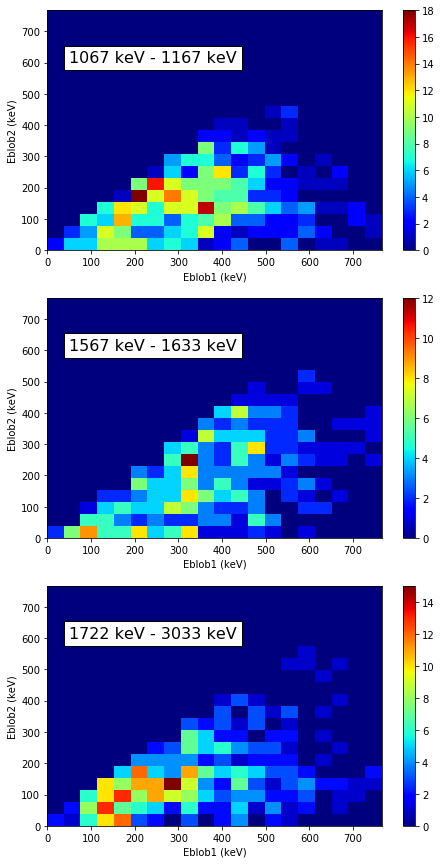

In [16]:
# Plot Eblob1 vs. Eblob2 in several intervals
nbins_blobs = 20

fig = plt.figure(3);
fig.set_figheight(15.0);
fig.set_figwidth(7.5);

# define intervals
eb1_low = 320000; eb1_high = 350000
eb2_low = 470000; eb2_high = 490000
eb3_low = 516600; eb3_high = 910000

# axes
ax_low = 15000; ax_high = 195000

# histogram range
hrange = 230000

# cuts
cuts_1 = ((l_etrk > eb1_low) & (l_etrk < eb1_high) & (l_ltrk > DIST_CUT))
cuts_2 = ((l_etrk > eb2_low) & (l_etrk < eb2_high) & (l_ltrk > DIST_CUT))
cuts_3 = ((l_etrk > eb3_low) & (l_etrk < eb3_high) & (l_ltrk > DIST_CUT))

print("Number of events I1 ({0} keV, {1} keV): {2}".format(eb1_low*CAL_FACTOR,eb1_high*CAL_FACTOR,len(l_eblob1[cuts_1])))
print("Number of events I2 ({0} keV, {1} keV): {2}".format(eb2_low*CAL_FACTOR,eb2_high*CAL_FACTOR,len(l_eblob1[cuts_2])))
print("Number of events I3 ({0} keV, {1} keV): {2}".format(eb3_low*CAL_FACTOR,eb3_high*CAL_FACTOR,len(l_eblob1[cuts_3])))

# interval 1
ax1 = fig.add_subplot(311);
hxy, xxy, yxy = np.histogram2d(l_eblob1[cuts_1]*CAL_FACTOR, l_eblob2[cuts_1]*CAL_FACTOR, normed=False, bins=(nbins_blobs, nbins_blobs), range=[[0,hrange*CAL_FACTOR],[0,hrange*CAL_FACTOR]])
ax1.text(50, 600, '{0:.4g} keV - {1:.4g} keV'.format(eb1_low*CAL_FACTOR,eb1_high*CAL_FACTOR), 
         bbox={'facecolor':'white', 'alpha':1.0, 'pad':5},fontsize=16)
extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp1 = ax1.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax1.set_xlabel("Eblob1 (keV)")
ax1.set_ylabel("Eblob2 (keV)")
plt.colorbar(sp1)

# interval 2
ax2 = fig.add_subplot(312);
hxy, xxy, yxy = np.histogram2d(l_eblob1[cuts_2]*CAL_FACTOR, l_eblob2[cuts_2]*CAL_FACTOR, normed=False, bins=(nbins_blobs, nbins_blobs), range=[[0,hrange*CAL_FACTOR],[0,hrange*CAL_FACTOR]])
ax2.text(50, 600, '{0:.4g} keV - {1:.4g} keV'.format(eb2_low*CAL_FACTOR,eb2_high*CAL_FACTOR), 
         bbox={'facecolor':'white', 'alpha':1.0, 'pad':5},fontsize=16)
extent2 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp2 = ax2.imshow(hxy, extent=extent2, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax2.set_xlabel("Eblob1 (keV)")
ax2.set_ylabel("Eblob2 (keV)")
plt.colorbar(sp2)

# interval 3
ax3 = fig.add_subplot(313);
hxy, xxy, yxy = np.histogram2d(l_eblob1[cuts_3]*CAL_FACTOR, l_eblob2[cuts_3]*CAL_FACTOR, normed=False, bins=(nbins_blobs, nbins_blobs), range=[[0,hrange*CAL_FACTOR],[0,hrange*CAL_FACTOR]])
ax3.text(50, 600, '{0:.4g} keV - {1:.4g} keV'.format(eb3_low*CAL_FACTOR,eb3_high*CAL_FACTOR), 
         bbox={'facecolor':'white', 'alpha':1.0, 'pad':5},fontsize=16)
extent3 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp3 = ax3.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax3.set_xlabel("Eblob1 (keV)")
ax3.set_ylabel("Eblob2 (keV)")
plt.colorbar(sp3)

--------------------------

# Distributions and analysis of all events
At this point we have a list of hit collections for all events from all specified runs, corrected by their appropriate lifetimes.  Here we extract key information from these hits.

In [17]:
# energy spectrum
ec_spec = []; ec_spec_zavg = []; rc_spec = []; zc_spec = []
for ee in range(len(hitc_cevt)):
    evt_E = sum([hh.E for hh in hitc_cevt[ee]])
    evt_X = sum([hh.X*hh.E for hh in hitc_cevt[ee]])
    evt_Y = sum([hh.Y*hh.E for hh in hitc_cevt[ee]])
    evt_Z = sum([hh.Z*hh.E for hh in hitc_cevt[ee]])
    if(evt_E > 0):
        evt_X /= evt_E
        evt_Y /= evt_E
        evt_Z /= evt_E
    
    evt_E_zavg = sum([hh.E for hh in hitc_gevt[ee]])/np.exp(-evt_Z/tlife)
    evt_R = np.sqrt(evt_X**2 + evt_Y**2)
    
    # add to distributions
    ec_spec.append(evt_E)
    ec_spec_zavg.append(evt_E_zavg)
    rc_spec.append(evt_R)
    zc_spec.append(evt_Z)

rc_spec = np.array(rc_spec)
zc_spec = np.array(zc_spec)
ec_spec = np.array(ec_spec)
ec_spec_zavg = np.array(ec_spec_zavg)

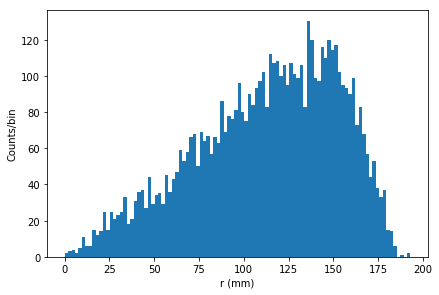

In [18]:
# Distribution in R
fig = plt.figure(1)
fig.set_figheight(10.0)
fig.set_figwidth(15.0)

# event distribution vs. R
ax1 = fig.add_subplot(221);
plt.hist(rc_spec,bins=100)
plt.xlabel('r (mm)')
plt.ylabel('Counts/bin')

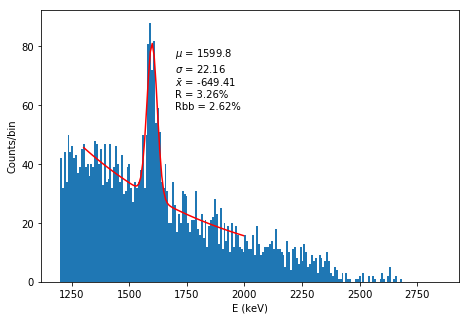

In [19]:
# Energy spectrum
fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

y, x, _ = plt.hist(ec_spec_zavg[(rc_spec < 150) & (zc_spec > 50) & (zc_spec < 500)]*CAL_FACTOR, 200, range=[1200,2850])

# Gaussian + exponential fit
x    = x[:-1] + np.diff(x) * 0.5
sel  = coref.in_range(x, 1300, 2000)
x, y = x[sel], y[sel]
f    = fitf.fit(gaussexpo, x, y, (550, 1600, 100, 20, -600, 1200))
plt.plot(x, f.fn(x), "r")
plt.text(510000*CAL_FACTOR, 4*max(y)/6, gaussexpotext(f.values))

# Gaussian fit
#f    = fitf.fit(fitf.gauss, x, y, (200, 480000*CAL_FACTOR, 10000*CAL_FACTOR))
#plt.text(510000*CAL_FACTOR, 5*max(y)/6, gausstext(f.values))

plt.xlabel('E (keV)')
plt.ylabel('Counts/bin')

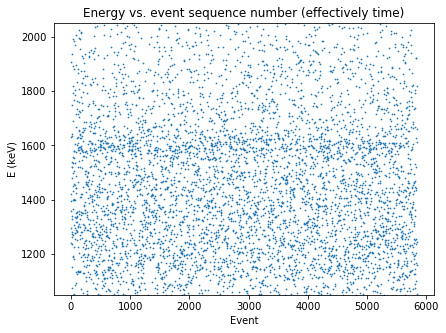

In [20]:
# Energy vs. event (effectively "time")
fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121)
ax1.scatter(range(len(ec_spec)),ec_spec*CAL_FACTOR,s=0.5)
#plt.scatter(range(len(ec_spec)),ec_spec*CAL_FACTOR,s=0.5)
plt.title("Energy vs. event sequence number (effectively time)")
plt.ylim([1050,2050])
#plt.xlim([0,550])
plt.xlabel('Event')
plt.ylabel('E (keV)')

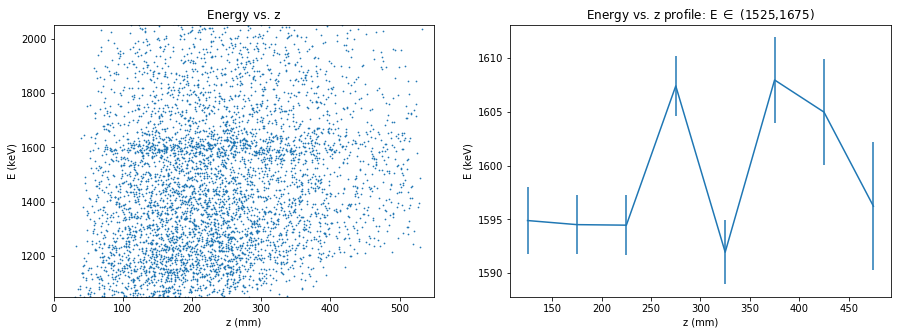

In [21]:
# Energy vs. z
zmin = 1525
zmax = 1675
zprof, Eprof, Eerr = fitf.profileX(zc_spec,ec_spec_zavg*CAL_FACTOR,nbins=8,xrange=(100,500),yrange=(zmin,zmax))

fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121);
ax1.scatter(zc_spec,ec_spec*CAL_FACTOR,s=0.5)
#plt.scatter(range(len(ec_spec)),ec_spec*CAL_FACTOR,s=0.5)
plt.title("Energy vs. z")
plt.ylim([1050,2050])
plt.xlim([0,550])
plt.xlabel('z (mm)')
plt.ylabel('E (keV)')

ax2 = fig.add_subplot(122);
ax2.errorbar(zprof,Eprof,yerr=Eerr)
#plt.scatter(range(len(ec_spec)),ec_spec*CAL_FACTOR,s=0.5)
#plt.ylim([100000,900000])
#plt.xlim([300000*CAL_FACTOR,800000*CAL_FACTOR])
plt.title("Energy vs. z profile: E $\in$ ({0},{1})".format(zmin,zmax))
plt.xlabel('z (mm)')
plt.ylabel('E (keV)')

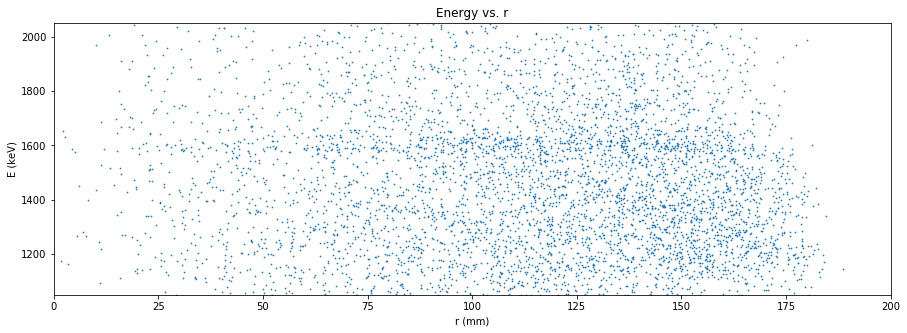

In [22]:
# Energy vs. r

fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(111);
ax1.scatter(rc_spec,ec_spec*CAL_FACTOR,s=0.5)
#plt.scatter(range(len(ec_spec)),ec_spec*CAL_FACTOR,s=0.5)
plt.title("Energy vs. r")
plt.ylim([1050,2050])
plt.xlim([0,200])
plt.xlabel('r (mm)')
plt.ylabel('E (keV)')

-----------------------

## Additional plots

In [ ]:
fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

ax1 = fig.add_subplot(111);
plt.hist(l_etrk[l_eblob1 < 225/CAL_FACTOR],bins=150,label='Single-track')
plt.hist(l_etrk[l_eblob1 > 225/CAL_FACTOR],bins=150,alpha=0.5,label='Double-track')
lnd = plt.legend(loc=1)
#plt.scatter(z_spec,e_spec,marker='.')
#plt.ylim([100000,900000])
#plt.xlim([20000,160000])
plt.xlabel('Energy (Q)')
plt.ylabel('Counts/bin')

In [ ]:
vox_size = np.array([15,15,15],dtype=np.int16)    # voxel size
blob_radius = 21.                    # blob radius in mm

nevt = 24
hitc = hitc_cevt[nevt]
print("Running Paolina for event {0} with blob radius {1}".format(nevt,blob_radius))

evt_E = sum([hh.E for hh in hitc])
print("Event {0} with total energy {1}".format(nevt,evt_E*CAL_FACTOR))

voxels = plf.voxelize_hits(hitc,vox_size)
trks = plf.make_track_graphs(voxels,vox_size)
for t in trks:
    etrk = sum([vox.E for vox in t.nodes()])
    trk_energies.append(etrk)
itmax = np.argmax([len(t) for t in trks])
print("Found {0} tracks; max containing {1} voxels; total of {2} voxels".format(len(trks),len(trks[itmax]),len(voxels)))

eblobs = plf.blob_energies(trks[itmax],blob_radius)
iter_eblobs = iter(eblobs)
if(len(eblobs) > 1):
    Eblob1, Eblob2 = next(iter_eblobs), next(iter_eblobs)
else:
    Eblob1 = Eblob2 = next(iter_eblobs)

# get the extremes
distances = plf.shortest_paths(trks[itmax])
exts = plf.find_extrema(distances)
iter_exts = iter(exts)
if(len(exts) > 1):
    a,b = next(iter_exts),next(iter_exts)
else:
    a = b = next(iter_exts)
print("Found {0} tracks of {1}; max containing {2} voxels; total of {3} voxels, distance = {4}".format(len(trks),len(hitc_cevt),len(trks[itmax]),len(voxels),distances[a][b]))
    
# plot the voxelized tracks
# 2D histogram
fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(20.0);

varr_x = []; varr_y = []; varr_z = []; varr_c = []
#for vv in trks[itmax]:
for vv in voxels:
    varr_x.append(vv.pos[0])
    varr_y.append(vv.pos[1])
    varr_z.append(vv.pos[2])
    varr_c.append(vv.E*CAL_FACTOR)
    
vtrk_max = 1.0*np.array([np.max(varr_x),np.max(varr_y),np.max(varr_z)])
vtrk_min = 1.0*np.array([np.min(varr_x),np.min(varr_y),np.min(varr_z)])
vtrk_len = np.abs(vtrk_max-vtrk_min)
vtrk_max = vtrk_max + 1.0*vtrk_len
vtrk_min = vtrk_min - 1.0*vtrk_len

# create the x-y projection
ax1 = fig.add_subplot(131);
hxy, xxy, yxy = np.histogram2d(varr_y, varr_x, weights=varr_c, normed=False, bins=(1.0*(vol_max[1]-vol_min[1])/vox_size[1], 1.0*(vol_max[0]-vol_min[0])/vox_size[0]), range=[[vol_min[1],vol_max[1]],[vol_min[0],vol_max[0]]])
extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp1 = ax1.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")
ax1.set_xlim([vtrk_min[0],vtrk_max[0]])
ax1.set_ylim([vtrk_min[1],vtrk_max[1]])
cbp1 = plt.colorbar(sp1)
cbp1.set_label('Energy (Q)')
ax1.scatter(a.pos[0],a.pos[1],marker='x',s=200,color='red')
ax1.scatter(b.pos[0],b.pos[1],marker='x',s=200,color='red')

# Create the y-z projection.
ax2 = fig.add_subplot(132)
hyz, xyz, yyz = np.histogram2d(varr_z, varr_y, weights=varr_c, normed=False, bins=(1.0*(vol_max[2]-vol_min[2])/vox_size[2], 1.0*(vol_max[1]-vol_min[1])/vox_size[1]), range=[[vol_min[2],vol_max[2]],[vol_min[1],vol_max[1]]])
extent2 = [yyz[0], yyz[-1], xyz[0], xyz[-1]]
sp2 = ax2.imshow(hyz, extent=extent2, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax2.set_xlabel("y (mm)")
ax2.set_ylabel("z (mm)")
ax2.set_xlim([vtrk_min[1],vtrk_max[1]])
ax2.set_ylim([vtrk_min[2],vtrk_max[2]])
cbp2 = plt.colorbar(sp2)
cbp2.set_label('Energy (Q)')
ax2.scatter(a.pos[1],a.pos[2],marker='x',s=200,color='red')
ax2.scatter(b.pos[1],b.pos[2],marker='x',s=200,color='red')

# Create the x-z projection.
ax3 = fig.add_subplot(133);
hxz, xxz, yxz = np.histogram2d(varr_z, varr_x, weights=varr_c, normed=False, bins=(1.0*(vol_max[2]-vol_min[2])/vox_size[2], 1.0*(vol_max[0]-vol_min[0])/vox_size[0]), range=[[vol_min[2],vol_max[2]],[vol_min[0],vol_max[0]]])
extent3 = [yxz[0], yxz[-1], xxz[0], xxz[-1]]
sp3 = ax3.imshow(hxz, extent=extent3, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax3.set_xlabel("x (mm)")
ax3.set_ylabel("z (mm)")
ax3.set_xlim([vtrk_min[0],vtrk_max[0]])
ax3.set_ylim([vtrk_min[2],vtrk_max[2]])
cbp3 = plt.colorbar(sp3);
cbp3.set_label('Energy (Q)');
ax3.scatter(a.pos[0],a.pos[2],marker='x',s=200,color='red')
ax3.scatter(b.pos[0],b.pos[2],marker='x',s=200,color='red')

print("Extreme0 at ({0},{1},{2}) with energy {3} keV".format(a.pos[0],a.pos[1],a.pos[2],Eblob1*CAL_FACTOR))
print("Extreme1 at ({0},{1},{2}) with energy {3} keV".format(b.pos[0],b.pos[1],b.pos[2],Eblob2*CAL_FACTOR))

------------------------------------------------------------------

# Lifetime check

In [ ]:
rnum = 4607
CAL_FACTOR = 0.0033
ctau_Emin = 1000/CAL_FACTOR; ctau_Emax = 2000/CAL_FACTOR

In [ ]:
fname = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/{0}/tracks/tracks_{1}.h5".format(rnum,rnum)
hits_all = load_hits(fname)
hits = load_hits_skipping_NN(fname)

# Modifies the list of non-NN hits.
merge_NN_hits(hits_all,hits)

In [ ]:
#l_taulife = np.arange(1087,1887,100)  # run 4595
#l_taulife = np.arange(1038,1838,100)  # run 4597
#l_taulife = np.arange(1056,1856,100)  # run 4599
#l_taulife = np.arange(1060,1860,100)  # run 4601
#l_taulife = np.arange(1055,1855,100)  # run 4603
#l_taulife = np.arange(1063,1863,100)  # run 4605
l_taulife = np.arange(1088,1888,100)  # run 4607

In [ ]:
# For each lifetime, perform the correction and fit.
l_emean = []; l_eres = []
for tlife in l_taulife:
    
    hitc_ctau = [] 
    etau_spec = []; e0tau_spec = []; ztau_spec = []; rtau_spec = []
    for ee,hc in hits.items():
        hc_corr = []
        evt_E = 0; evt_E0 = 0 
        evt_X = 0; evt_Y = 0; evt_Z = 0
        for hh in hc.hits:
            hecorr = hh.E*fcorr(hh.X,hh.Y)/np.exp(-hh.Z/tlife)
            hcorr = Hit(0,Cluster(0, xy(hh.X,hh.Y), xy(0,0), 0),hh.Z,hecorr)
            hc_corr.append(hcorr)
            evt_E += hecorr
            evt_E0 += hh.E
            evt_X += hh.X*hh.E
            evt_Y += hh.Y*hh.E
            evt_Z += hh.Z*hh.E

        # Compute event energy.
        if(evt_E > 0):
            evt_X /= evt_E
            evt_Y /= evt_E
            evt_Z /= evt_E
        evt_R = np.sqrt(evt_X**2 + evt_Y**2)
        if(evt_E > ctau_Emin and evt_E < ctau_Emax):
            etau_spec.append(evt_E*CAL_FACTOR)
            rtau_spec.append(evt_R)
            e0tau_spec.append(evt_E0)
            ztau_spec.append(evt_Z)
        
        hitc_ctau.append(hc_corr)
    
    etau_spec = np.array(etau_spec)
    rtau_spec = np.array(rtau_spec)
    e0tau_spec = np.array(e0tau_spec)
    ztau_spec = np.array(ztau_spec)
        
    # Perform the fit.
    fig = plt.figure()
    fig.set_figheight(5.0)
    fig.set_figwidth(7.5)    
    y, x, _ = plt.hist(etau_spec[(rtau_spec < 150)], 150, range=[1200,2000])
    x    = x[:-1] + np.diff(x) * 0.5
    sel  = fitf.in_range(x, 1400, 1800)
    x, y = x[sel], y[sel]
    f    = fitf.fit(gaussexpo, x, y, (550, 1600, 100, 50, -600, 1200))
    plt.plot(x, f.fn(x), "r")
    plt.text(510000*CAL_FACTOR, 4*max(y)/6, gaussexpotext(f.values))
    plt.savefig("fit_run_{0}_tlife_{1}.pdf".format(rnum,tlife))
    
    # Save the mean and resolution.
    mu = f.values[1]; sigma = f.values[2]
    res = 235. * sigma/mu
    l_emean.append(mu)
    l_eres.append(res)
    
    print("[Lifetime {0} mus] mean = {1}, resolution = {2} %FWHM; mean correction factor = {3}".format(tlife,mu,res,1590./mu))

---------------------